In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_classif, chi2

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler
from feature_engine.discretisation import EqualFrequencyDiscretiser

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, precision_score, recall_score, classification_report, confusion_matrix, make_scorer, fbeta_score

import scorecardpy as sc

from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
def display_data(df):
    df.columns = df.columns.str.lower() #huruf diperkecil semua untuk mempermudah slicing dan analisa
    return display(f"Jumlah Baris: {df.shape[0]}; Jumlah Kolom:{df.shape[1]}",df.head())

## <div style="color:white;display:fill;border-radius:8px;font-size:100%; letter-spacing:1.0px;"><p style="padding: 5px;color:white;text-align:left;"><b><span style='color:#e50000'>1. Data Understanding & Cleaning</span></b></p></div>

### <div style="color:white;display:fill;border-radius:8px;font-size:100%; letter-spacing:1.0px;"><p style="padding: 5px;color:white;text-align:left;"><b><span style='color:#e50000'>1.1 Data Understanding & Cleaning Master Table (Train)</span></b></p></div>

In [4]:
train = pd.read_csv(r"C:\Users\tamar\Downloads\home-credit-default-risk\application_train.csv")
display_data(train)

'Jumlah Baris: 307511; Jumlah Kolom:122'

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,entrances_avg,floorsmax_avg,floorsmin_avg,landarea_avg,livingapartments_avg,livingarea_avg,nonlivingapartments_avg,nonlivingarea_avg,apartments_mode,basementarea_mode,years_beginexpluatation_mode,years_build_mode,commonarea_mode,elevators_mode,entrances_mode,floorsmax_mode,floorsmin_mode,landarea_mode,livingapartments_mode,livingarea_mode,nonlivingapartments_mode,nonlivingarea_mode,apartments_medi,basementarea_medi,years_beginexpluatation_medi,years_build_medi,commonarea_medi,elevators_medi,entrances_medi,floorsmax_medi,floorsmin_medi,landarea_medi,livingapartments_medi,livingarea_medi,nonlivingapartments_medi,nonlivingarea_medi,fondkapremont_mode,housetype_mode,totalarea_mode,wallsmaterial_mode,emergencystate_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [5]:
test = pd.read_csv(r"C:\Users\tamar\Downloads\home-credit-default-risk\application_test.csv")
display_data(test)

'Jumlah Baris: 48744; Jumlah Kolom:121'

,sk_id_curr,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,entrances_avg,floorsmax_avg,floorsmin_avg,landarea_avg,livingapartments_avg,livingarea_avg,nonlivingapartments_avg,nonlivingarea_avg,apartments_mode,basementarea_mode,years_beginexpluatation_mode,years_build_mode,commonarea_mode,elevators_mode,entrances_mode,floorsmax_mode,floorsmin_mode,landarea_mode,livingapartments_mode,livingarea_mode,nonlivingapartments_mode,nonlivingarea_mode,apartments_medi,basementarea_medi,years_beginexpluatation_medi,years_build_medi,commonarea_medi,elevators_medi,entrances_medi,floorsmax_medi,floorsmin_medi,landarea_medi,livingapartments_medi,livingarea_medi,nonlivingapartments_medi,nonlivingarea_medi,fondkapremont_mode,housetype_mode,totalarea_mode,wallsmaterial_mode,emergencystate_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married

In [6]:
def cek_data(df):
    pd.set_option('display.max_rows', 122)

    results = []
    for col in df.columns:
        missings = df[col].isnull().sum()
        missings_prcntg = round(((df[col].isnull().sum())/(df.shape[0]))*100, 2)
        data_types = df[col].dtypes
        nuniques = df[col].nunique()
        uniques = df[col].unique()
        results.append([col, missings, missings_prcntg, data_types, nuniques, uniques])
    meta_data = pd.DataFrame(results, columns=['col', 'missings','missings_%', 'data_types', 'nuniques', 'uniques'])
    return meta_data.sort_values('missings', ascending=False)

In [7]:
meta_data = cek_data(train)
meta_data

,col,missings,missings_%,data_types,nuniques,uniques
76,commonarea_medi,214865,69.87,float64,3202,"[0.0144, 0.0608, nan, 0.0585, 0.115, 0.0018, 0..."
48,commonarea_avg,214865,69.87,float64,3181,"[0.0143, 0.0605, nan, 0.0582, 0.1143, 0.0018, ..."
62,commonarea_mode,214865,69.87,float64,3128,"[0.0144, 0.0497, nan, 0.0587, 0.1153, 0.0018, ..."
70,nonlivingapartments_mode,213514,69.43,float64,167,"[0.0, nan, 0.0195, 0.0078, 0.0039, 0.0661, 0.1..."
56,nonlivingapartments_avg,213514,69.43,float64,386,"[0.0, 0.0039, nan, 0.0193, 0.0077, 0.0019, 0.0..."
84,nonlivingapartments_medi,213514,69.43,float64,214,"[0.0, 0.0039, nan, 0.0194, 0.0078, 0.0019, 0.0..."
86,fondkapremont_mode,210295,68.39,object,4,"[reg oper account, nan, org spec account, reg ..."
68,livingapartments_mode,210199,68.35,float64,736,"[0.022, 0.079, nan, 0.1313, 0.3113, 0.0248, 0...."
54,livingapartments_avg,210199,68.35,float64,1868,"[0.0202, 0.0773, nan, 0.1202, 0.2849, 0.0227, ..."
82,livingapartments_medi,210199,68.35,float64,1097,"[0.0205, 0.0787, nan, 0.1223, 0.2899, 0.0231, ..."


#### Statistik Deskriptif

In [8]:
round(train.describe().T, 1)

,count,mean,std,min,25%,50%,75%,max
sk_id_curr,307511.0,278180.5,102790.2,100002.0,189145.5,278202.0,367142.5,456255.0
target,307511.0,0.1,0.3,0.0,0.0,0.0,0.0,1.0
cnt_children,307511.0,0.4,0.7,0.0,0.0,0.0,1.0,19.0
amt_income_total,307511.0,168797.9,237123.1,25650.0,112500.0,147150.0,202500.0,117000000.0
amt_credit,307511.0,599026.0,402490.8,45000.0,270000.0,513531.0,808650.0,4050000.0
amt_annuity,307499.0,27108.6,14493.7,1615.5,16524.0,24903.0,34596.0,258025.5
amt_goods_price,307233.0,538396.2,369446.5,40500.0,238500.0,450000.0,679500.0,4050000.0
region_population_relative,307511.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1
days_birth,307511.0,-16037.0,4364.0,-25229.0,-19682.0,-15750.0,-12413.0,-7489.0
days_employed,307511.0,63815.0,141275.8,-17912.0,-2760.0,-1213.0,-289.0,365243.0


#### Imputasi missing values

- Ada banyak kolom yang memiliki `missing values di atas 30%`, terutama kolom-kolom terkait karakteristik tempat tinggal peminjam/pemohon. Sebelum memutuskan untuk menghapus kolom/ mengimputasi kolom, saya akan `memeriksa mutual info` masing-masing kolom tersebut dengan kolom target menggunakan `mutual_info_classif` dari sklearn.

- Skor MI (mutial information) mendekati nol hampir tidak berguna, dan mi=0 berarti tidak ada hubungan sama sekali dengan target.

In [9]:
# kolom-kolom dengan missing value di atas 30% (data numerik)
missing_cols_over30 = meta_data[(meta_data['missings_%']>30) & (meta_data['data_types']!='object')]['col'].values
missing_cols_over30

array(['commonarea_medi', 'commonarea_avg', 'commonarea_mode',
       'nonlivingapartments_mode', 'nonlivingapartments_avg',
       'nonlivingapartments_medi', 'livingapartments_mode',
       'livingapartments_avg', 'livingapartments_medi', 'floorsmin_avg',
       'floorsmin_mode', 'floorsmin_medi', 'years_build_medi',
       'years_build_mode', 'years_build_avg', 'own_car_age',
       'landarea_medi', 'landarea_mode', 'landarea_avg',
       'basementarea_medi', 'basementarea_avg', 'basementarea_mode',
       'ext_source_1', 'nonlivingarea_mode', 'nonlivingarea_avg',
       'nonlivingarea_medi', 'elevators_medi', 'elevators_avg',
       'elevators_mode', 'apartments_medi', 'apartments_avg',
       'apartments_mode', 'entrances_medi', 'entrances_avg',
       'entrances_mode', 'livingarea_avg', 'livingarea_mode',
       'livingarea_medi', 'floorsmax_mode', 'floorsmax_medi',
       'floorsmax_avg', 'years_beginexpluatation_mode',
       'years_beginexpluatation_medi', 'years_beginexpluata

In [10]:
train_temp = train.dropna(subset=missing_cols_over30) # hapus subset missing sementara(temporary)
mi = mutual_info_classif(train_temp[missing_cols_over30], train_temp['target'])

mi_df = pd.DataFrame({'Feature': missing_cols_over30, 'MI_Score': mi})
mi_df = mi_df.sort_values(by='MI_Score', ascending=False)

print(mi_df)

                         Feature  MI_Score
22                  ext_source_1  0.012871
0                commonarea_medi  0.004376
41  years_beginexpluatation_mode  0.003205
38                floorsmax_mode  0.001857
1                 commonarea_avg  0.001564
15                   own_car_age  0.001538
4        nonlivingapartments_avg  0.001471
16                 landarea_medi  0.001408
29               apartments_medi  0.001133
2                commonarea_mode  0.001018
21             basementarea_mode  0.000838
43   years_beginexpluatation_avg  0.000551
3       nonlivingapartments_mode  0.000516
34                entrances_mode  0.000487
36               livingarea_mode  0.000368
32                entrances_medi  0.000190
39                floorsmax_medi  0.000091
6          livingapartments_mode  0.000085
33                 entrances_avg  0.000001
30                apartments_avg  0.000000
35                livingarea_avg  0.000000
31               apartments_mode  0.000000
27         

- Karena kolom `ext_source_1` (skor kredit dari sumber eksternal 1) memiliki missing values di atas 50%, tetapi merupakan kolom yang penting untuk prediksi target (mi_score tertinggi), maka kolom ini tidak dihapus.
- Namun, karena proporsi missing values sangat tinggi, maka diperlukan teknik imputasi yang lebih canggih dibandingkan hanya mengisi _missing values_ dengan nilai statistik (mean, median, mode, dll). Sebab, mengisi missing value dengan satu nilai yang sama akan memberikan ketimpangan nilai (imbalance).

In [11]:
# hapus seluruh kolom dengan missing values di atas 30% (kecuali kolom ext_source)
cols_to_drop = meta_data[(meta_data['missings_%']>30) & ~meta_data['col'].str.contains('ext_source')]['col'].values

train = train.drop(columns=cols_to_drop)
test = test.drop(columns=cols_to_drop)

In [12]:
numerical_cols = train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = train.select_dtypes(include=['object']).columns

imputer = IterativeImputer(max_iter=10, random_state=0, min_value=0)
train[numerical_cols] = imputer.fit_transform(train[numerical_cols])

- Untuk data kategori, nilai yang hilang diisi dengan modus:

In [13]:
for col in categorical_cols:
    if train[col].isnull().sum() > 0:
        train[col] = train[col].fillna(train[col].mode()[0])

In [14]:
# cek data setelah imputasi dilakukan
meta_data = cek_data(train)
meta_data

,col,missings,missings_%,data_types,nuniques,uniques
0,sk_id_curr,0,0.0,float64,307511,"[100002.0, 100003.0, 100004.0, 100006.0, 10000..."
37,live_city_not_work_city,0,0.0,float64,2,"[0.0, 1.0]"
53,flag_document_8,0,0.0,float64,2,"[0.0, 1.0]"
52,flag_document_7,0,0.0,float64,2,"[0.0, 1.0]"
51,flag_document_6,0,0.0,float64,2,"[0.0, 1.0]"
50,flag_document_5,0,0.0,float64,2,"[0.0, 1.0]"
49,flag_document_4,0,0.0,float64,2,"[0.0, 1.0]"
48,flag_document_3,0,0.0,float64,2,"[1.0, 0.0]"
47,flag_document_2,0,0.0,float64,2,"[0.0, 1.0]"
46,days_last_phone_change,0,0.0,float64,3773,"[-1134.0, -828.0, -815.0, -617.0, -1106.0, -25..."


In [15]:
round(train.describe().T, 1)

,count,mean,std,min,25%,50%,75%,max
sk_id_curr,307511.0,278180.5,102790.2,100002.0,189145.5,278202.0,367142.5,456255.0
target,307511.0,0.1,0.3,0.0,0.0,0.0,0.0,1.0
cnt_children,307511.0,0.4,0.7,0.0,0.0,0.0,1.0,19.0
amt_income_total,307511.0,168797.9,237123.1,25650.0,112500.0,147150.0,202500.0,117000000.0
amt_credit,307511.0,599026.0,402490.8,45000.0,270000.0,513531.0,808650.0,4050000.0
amt_annuity,307511.0,27108.6,14493.6,1615.5,16524.0,24903.0,34596.0,258025.5
amt_goods_price,307511.0,538130.5,369422.8,40500.0,238500.0,450000.0,679500.0,4050000.0
region_population_relative,307511.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1
days_birth,307511.0,-16037.0,4364.0,-25229.0,-19682.0,-15750.0,-12413.0,-7489.0
days_employed,307511.0,63815.0,141275.8,-17912.0,-2760.0,-1213.0,-289.0,365243.0


#### Catatan Singkat Penjelasan Kolom

- **flag_document**: kolom-kolom biner (flag) yang menunjukkan apakah pemohon kredit telah menyerahkan dokumen tertentu

        FLAG_DOCUMENT_2: Surat izin mengemudi.
        FLAG_DOCUMENT_3: Kartu identitas (KTP).
        FLAG_DOCUMENT_4: Paspor.
        FLAG_DOCUMENT_5: Surat keterangan kerja.
        FLAG_DOCUMENT_6: Slip gaji.
        FLAG_DOCUMENT_7: Rekening koran.
        FLAG_DOCUMENT_8: Surat keterangan domisili.
        FLAG_DOCUMENT_9: NPWP (Nomor Pokok Wajib Pajak).
        FLAG_DOCUMENT_10: Akta kelahiran.
        FLAG_DOCUMENT_11: Kartu keluarga.
        FLAG_DOCUMENT_12: Surat nikah.
        FLAG_DOCUMENT_13: Surat perjanjian sewa.
        FLAG_DOCUMENT_14: Surat kepemilikan properti.
        FLAG_DOCUMENT_15: Surat keterangan penghasilan.
        FLAG_DOCUMENT_16: Laporan keuangan pribadi.
        FLAG_DOCUMENT_17: Surat referensi bank.
        FLAG_DOCUMENT_18: Surat keterangan pajak.
        FLAG_DOCUMENT_19: Surat kuasa.
        FLAG_DOCUMENT_20: Surat pernyataan.
        FLAG_DOCUMENT_21: Dokumen lainnya.

- **flag_own_car, flag_own_realty, flag_mobil, flag_emp_phone, flag_work_phone, flag_cont_mobile, flag_phone, flag_email**

    kolom-kolom biner (flag) yang memberikan informasi tentang kepemilikan aset dan ketersediaan kontak pemohon kredit (apakah memiliki properti, rumah, mobil, email, dll)

- **obs_30_cnt_social_circle,	def_30_cnt_social_circle,	obs_60_cnt_social_circle,	def_60_cnt_social_circle**

    informasi tentang lingkaran sosial pemohon kredit, khususnya terkait keterlambatan pembayaran (observed) dan default (defaulted) dalam 30 dan 60 hari terakhir. Misalnya: obs_30_cnt_social_circle = Jumlah orang dalam lingkaran sosial pemohon yang mengalami keterlambatan pembayaran (observed) dalam 30 hari terakhir

- **amt_income_total,	amt_credit,	amt_annuity,	amt_goods_price**

    fitur-fitur numerik yang memberikan informasi penting tentang keuangan pemohon dan pinjaman yang diajukan, di mana amt: amount. Misalnya,  amt_credit adalah jumlah total kredit yang diajukan oleh pemohon dan amt_annuity adalah jumlah pembayaran tahunan untuk pinjaman

- **amt_req_credit_bureau_hour,	amt_req_credit_bureau_day,	amt_req_credit_bureau_week,	amt_req_credit_bureau_mon,	amt_req_credit_bureau_qrt,	amt_req_credit_bureau_year**

    informasi tentang frekuensi permintaan informasi ke Credit Bureau tentang klien dalam berbagai rentang waktu. Contohnya, amt_req_credit_bureau_hour --> Jumlah permintaan laporan kredit ke biro kredit dalam 1 jam terakhir.

- **cnt_children,	cnt_fam_members**:
    Jumlah tanggungan anak dan anggota keluarga peminjam

- **name_contract_type,	name_type_suite,	name_income_type,	name_education_type,	name_family_status,	name_housing_type**

    kolom-kolom kategorikal yang memberikan informasi tentang profil pemohon dan jenis pinjaman. Contoh:
    - `name_type_suite`: Jenis suite yang menyertai pemohon saat mengajukan pinjaman.
        
        `Unaccompanied`: Pemohon mengajukan pinjaman sendirian.

        `Family`: Pemohon mengajukan pinjaman bersama keluarga.

        `Spouse, partner`: Pemohon mengajukan pinjaman bersama pasangan.

        `Children`: Pemohon mengajukan pinjaman bersama anak-anak.

        `Other_B`: Jenis suite lainnya.

- **days_birth,	days_employed,	days_registration,	days_id_publish,	days_last_phone_change**

    kolom-kolom numerik yang memberikan informasi tentang usia, riwayat pekerjaan, dan aktivitas terbaru pemohon kredit. Contohnya, `days_id_publish`: Jumlah hari sejak pemohon mengubah ID mereka (dihitung dari hari pengajuan kredit). Misalnya, -500 berarti pemohon mengubah ID sekitar 1,4 tahun yang lalu (500 hari / 365 hari).

- **region_population_relative,	region_rating_client,	region_rating_client_w_city,	reg_region_not_live_region,	reg_region_not_work_region,	live_region_not_work_region**

    informasi lokasi geografis dan karakteristik wilayah tempat pemohon tinggal atau bekerja. Contoh: `reg_region_not_work_region` adalah Flag yang menunjukkan apakah wilayah registrasi pemohon berbeda dengan wilayah tempat kerjanya. Kemudian, `live_region_not_work_region` menandakan apakah wilayah tempat tinggal pemohon berbeda dengan wilayah tempat kerjanya.

#### Distribusi Data Kategorik
- Terdapat jenis data yang memiliki urutan, seperti: level edukasi ('name_education_type') dan hari pengajuan pinjaman ('weekday_appr_process_start')
- Agar nantinya model dapat mengenali urutan ini, dan memperlakukan data sesuai urutannya, maka saya ubah dahulu tipe datanya menjadi categorical dengan urutan:

In [16]:
education_levels = ["Lower secondary", "Secondary / secondary special", 
                    "Incomplete higher", "Higher education", "Academic degree"]
train['name_education_type'] = pd.Categorical(train['name_education_type'],categories=education_levels, ordered=True)
test['name_education_type'] = pd.Categorical(test['name_education_type'],categories=education_levels, ordered=True)

day_order = ['MONDAY', 'TUESDAY', 'WEDNESDAY', 'THURSDAY', 'FRIDAY', 'SATURDAY', 'SUNDAY']
train['weekday_appr_process_start'] = pd.Categorical(train['weekday_appr_process_start'], categories=day_order, ordered=True)
test['weekday_appr_process_start'] = pd.Categorical(test['weekday_appr_process_start'], categories=day_order, ordered=True)

In [17]:
def distribusi_data_kardinalitas_rendah(df, list_col, x, y):
    custom_palette = ["blue", "red"]
    for i,col in enumerate(list_col):
        plt.subplot(y,x,(i+1))
        ax = sns.countplot(df, x=col, hue='target', palette=custom_palette)

        plt.title(f"Distribusi {col}")
        plt.xticks(fontsize=9, rotation=45)
        plt.yticks(fontsize=9)

        containers = ax.containers
        for container in containers:
            ax.bar_label(container, fontsize=8)

    plt.tight_layout()

In [18]:
obj_cols = meta_data[(meta_data['data_types'] == 'object') & (meta_data['nuniques']<50)]['col'].values
obj_cols

array(['name_housing_type', 'name_family_status', 'name_education_type',
       'name_income_type', 'name_type_suite', 'flag_own_realty',
       'flag_own_car', 'code_gender', 'name_contract_type',
       'weekday_appr_process_start'], dtype=object)

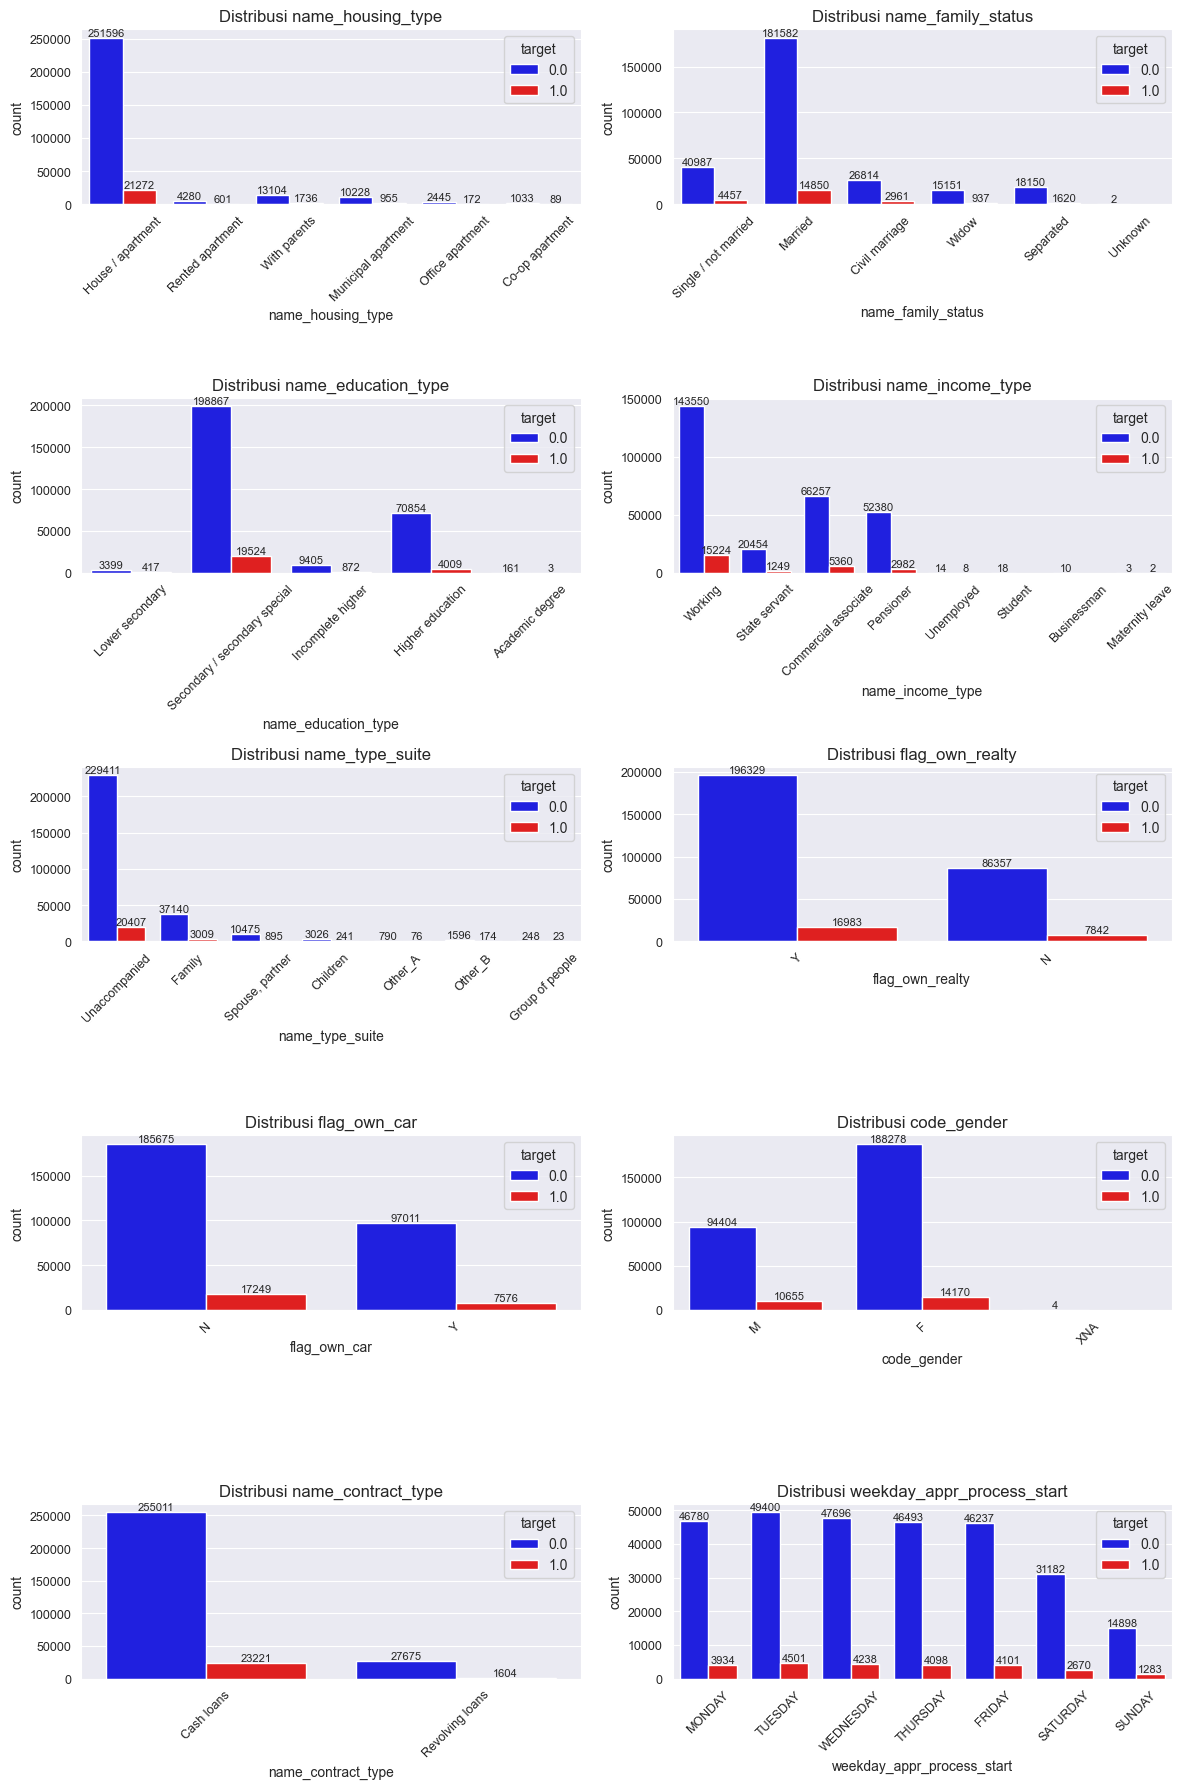

In [19]:
custom_palette = ["blue", "red"]
sns.set_style('darkgrid')

plt.figure(figsize=(12,18))
distribusi_data_kardinalitas_rendah(train, obj_cols, 2, 5)

#### Distribusi Data Numerik Diskrit (Terbatas, Kardinalitas/ Jumlah Nilai Unik Rendah)

In [20]:
flag_cols = train.columns[train.columns.str.contains('flag_')]
print(flag_cols)
print(len(flag_cols))

Index(['flag_own_car', 'flag_own_realty', 'flag_mobil', 'flag_emp_phone',
       'flag_work_phone', 'flag_cont_mobile', 'flag_phone', 'flag_email',
       'flag_document_2', 'flag_document_3', 'flag_document_4',
       'flag_document_5', 'flag_document_6', 'flag_document_7',
       'flag_document_8', 'flag_document_9', 'flag_document_10',
       'flag_document_11', 'flag_document_12', 'flag_document_13',
       'flag_document_14', 'flag_document_15', 'flag_document_16',
       'flag_document_17', 'flag_document_18', 'flag_document_19',
       'flag_document_20', 'flag_document_21'],
      dtype='object')
28


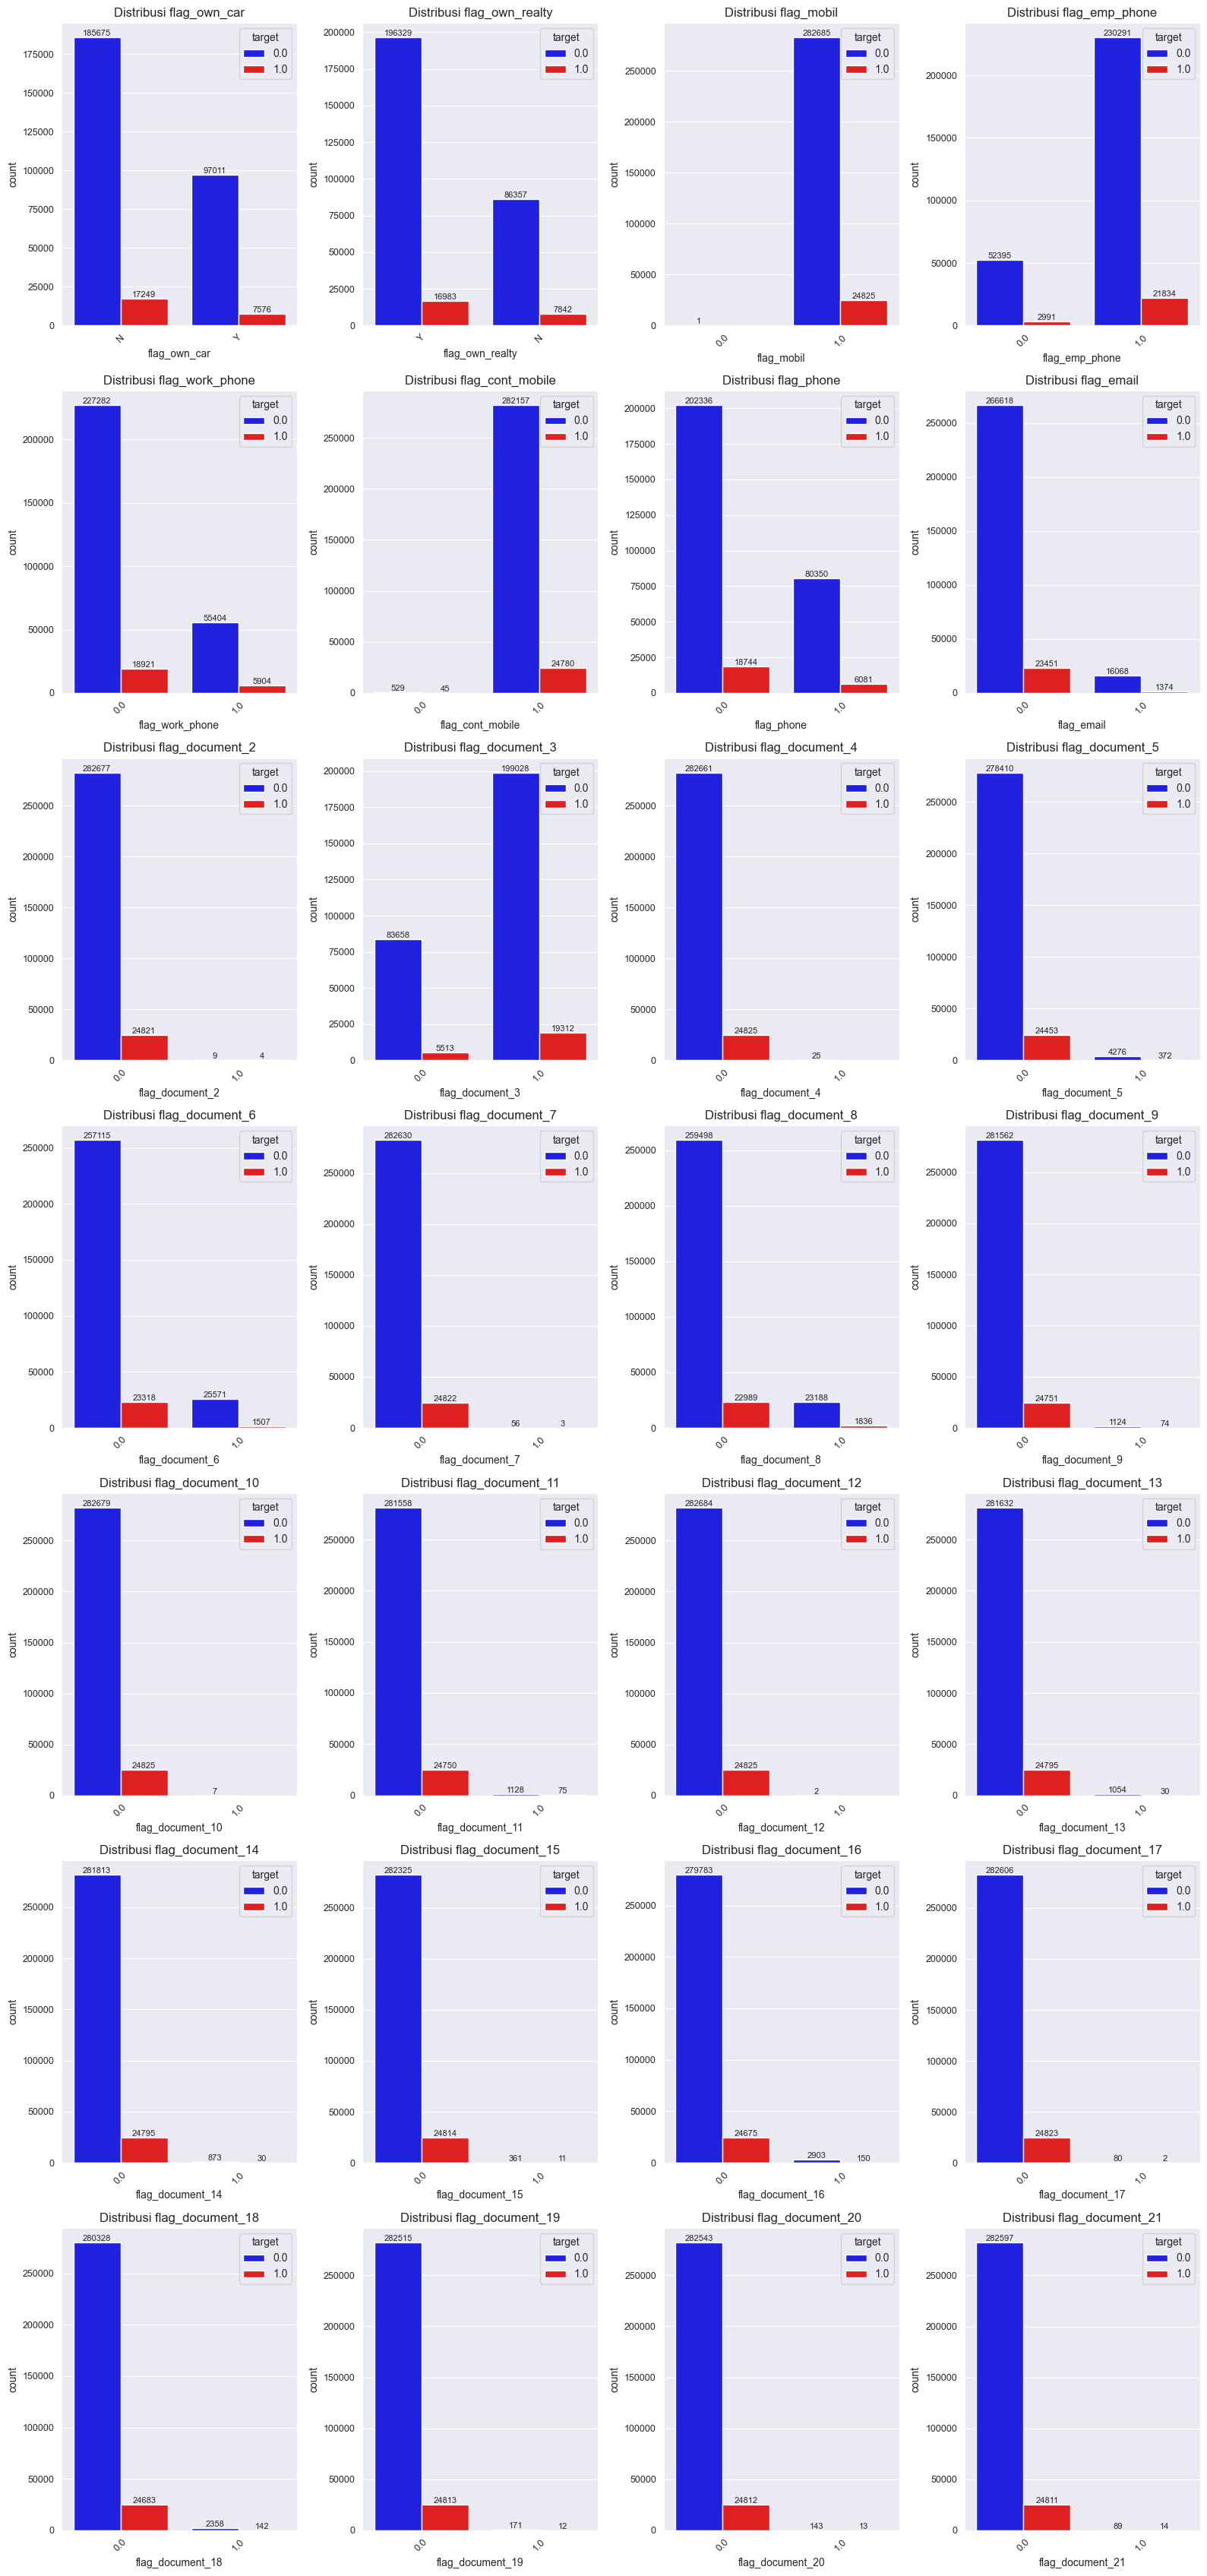

In [21]:
plt.figure(figsize=(16,34))
distribusi_data_kardinalitas_rendah(train, flag_cols, 4, 7)

In [22]:
other_low_cardinal_num_cols = meta_data[(meta_data['nuniques']<=10)
                                  & (~meta_data['col'].isin(flag_cols))
                                  & (meta_data['data_types'] != 'object')]['col'].values
other_low_cardinal_num_cols = [col for col in other_low_cardinal_num_cols if col != 'target']
other_low_cardinal_num_cols

['live_city_not_work_city',
 'reg_city_not_work_city',
 'reg_city_not_live_city',
 'region_rating_client',
 'live_region_not_work_region',
 'reg_region_not_work_region',
 'reg_region_not_live_region',
 'region_rating_client_w_city']

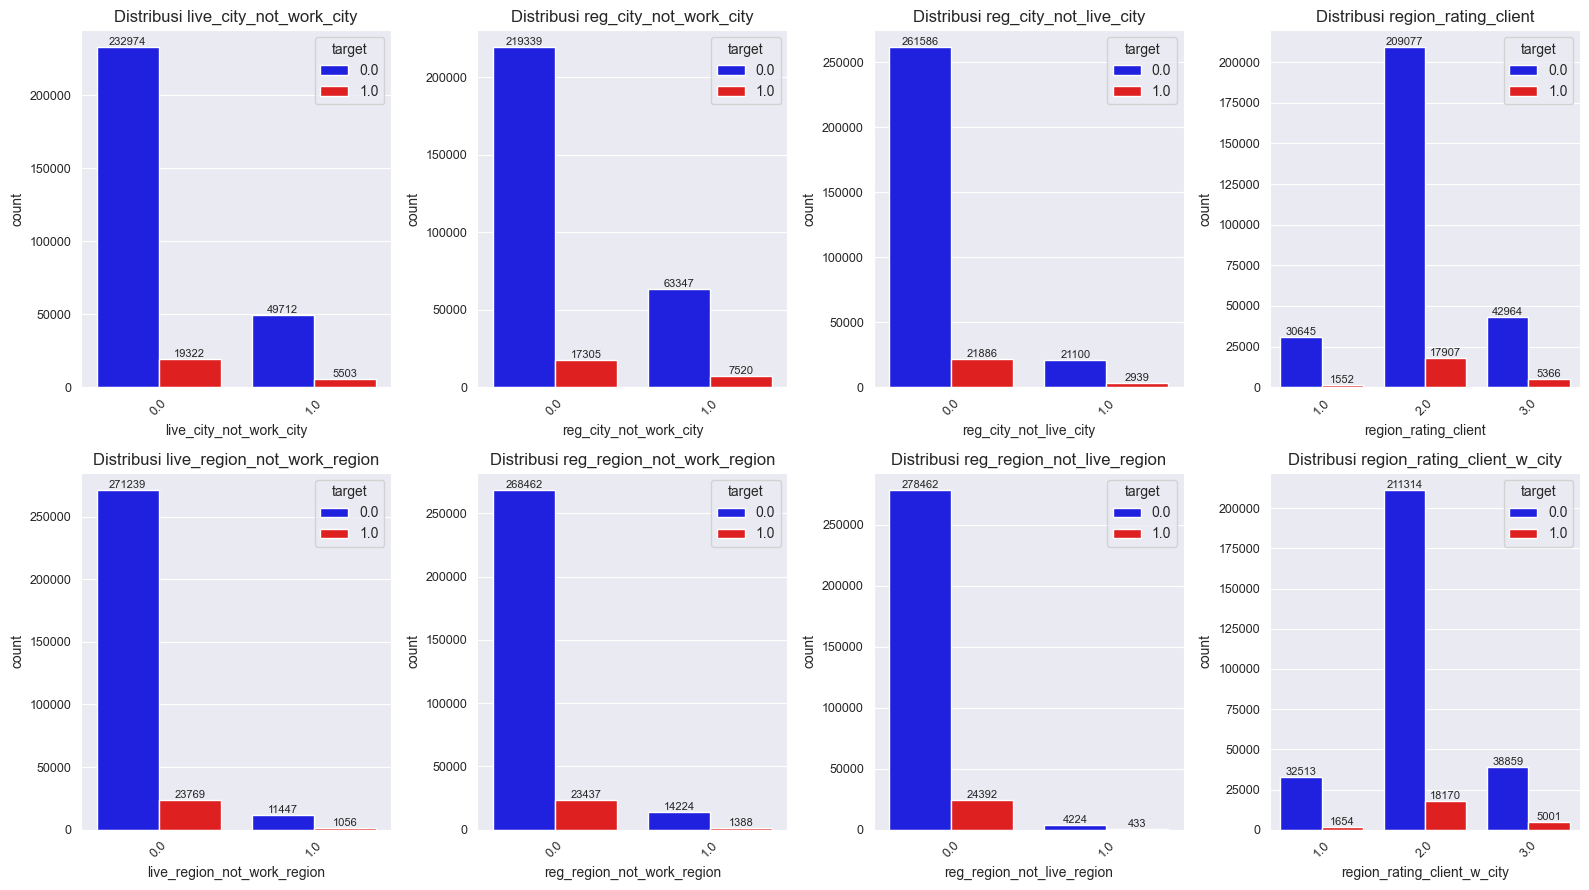

In [23]:
plt.figure(figsize=(16,9))
distribusi_data_kardinalitas_rendah(train, other_low_cardinal_num_cols, 4, 2)

#### Distribusi Data Numerik Kontinu

In [24]:
# kolom yang berisi nilai-nilai negatif 
days_cols = train.columns[train.columns.str.contains('days_')]
days_cols

Index(['days_birth', 'days_employed', 'days_registration', 'days_id_publish',
       'days_last_phone_change'],
      dtype='object')

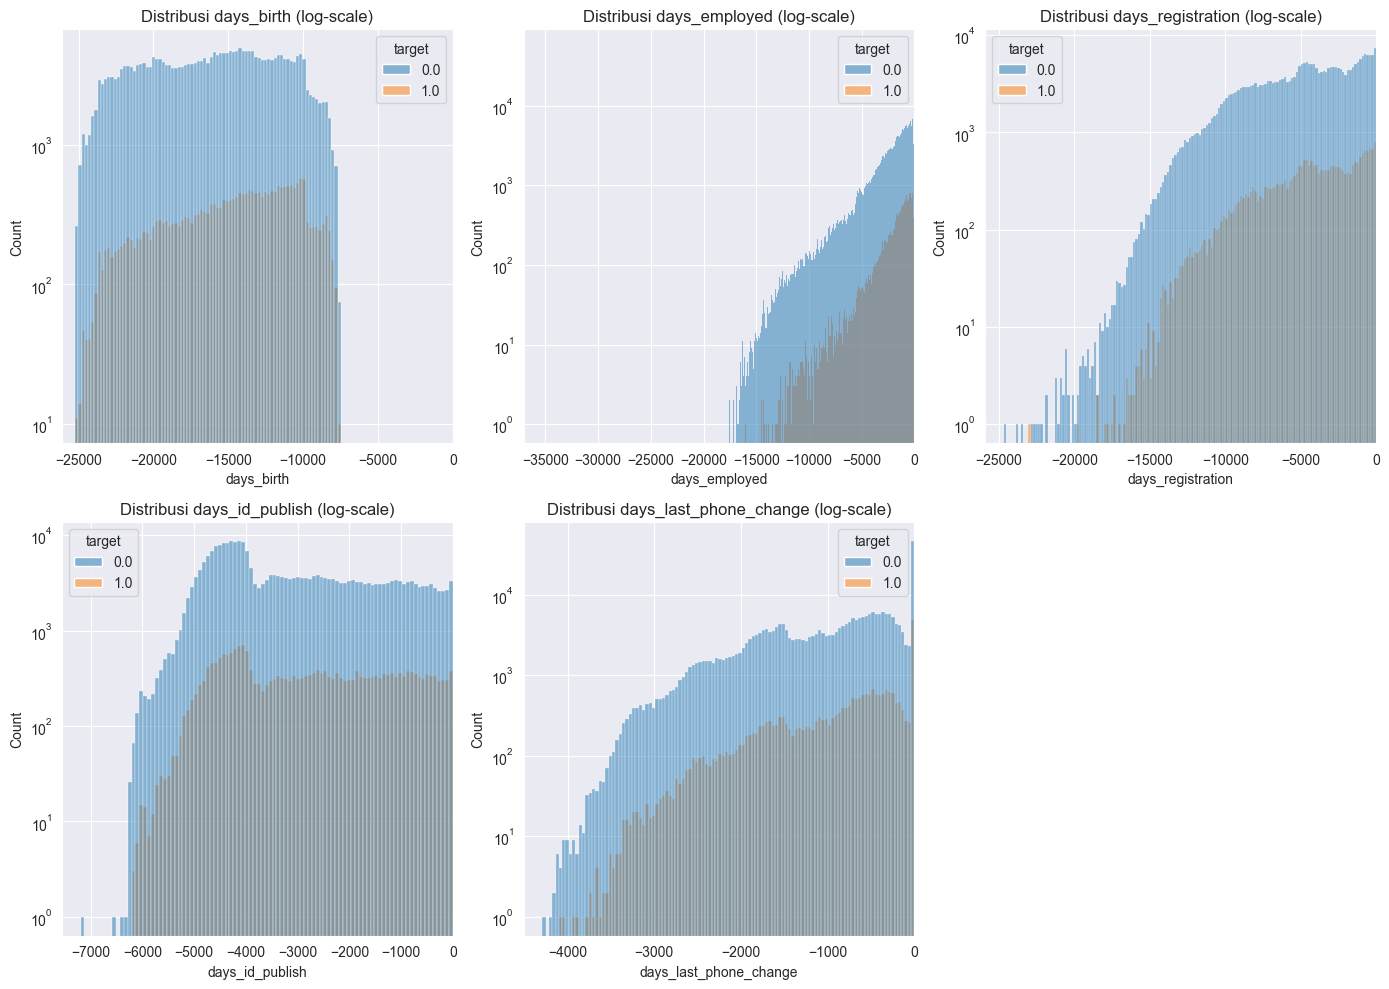

In [25]:
plt.figure(figsize=(14,10))
for i,col in enumerate(days_cols):
    plt.subplot(2,3, (i+1))
    sns.histplot(train, x=col, hue='target')
    plt.title(f"Distribusi {col} (log-scale)")
    plt.xlim(right=0)
    plt.yscale('log')
plt.tight_layout()

In [26]:
num_cont_cols = meta_data[(meta_data['data_types'] != 'object') & (meta_data['nuniques'] > 100)]['col'].values
num_cont_cols = [col for col in num_cont_cols if col != 'sk_id_curr' and col not in days_cols]
num_cont_cols

['def_60_cnt_social_circle',
 'obs_60_cnt_social_circle',
 'def_30_cnt_social_circle',
 'obs_30_cnt_social_circle',
 'ext_source_3',
 'ext_source_2',
 'ext_source_1',
 'amt_req_credit_bureau_qrt',
 'amt_req_credit_bureau_mon',
 'amt_req_credit_bureau_week',
 'amt_req_credit_bureau_day',
 'amt_req_credit_bureau_hour',
 'amt_goods_price',
 'amt_annuity',
 'amt_credit',
 'amt_income_total',
 'amt_req_credit_bureau_year']

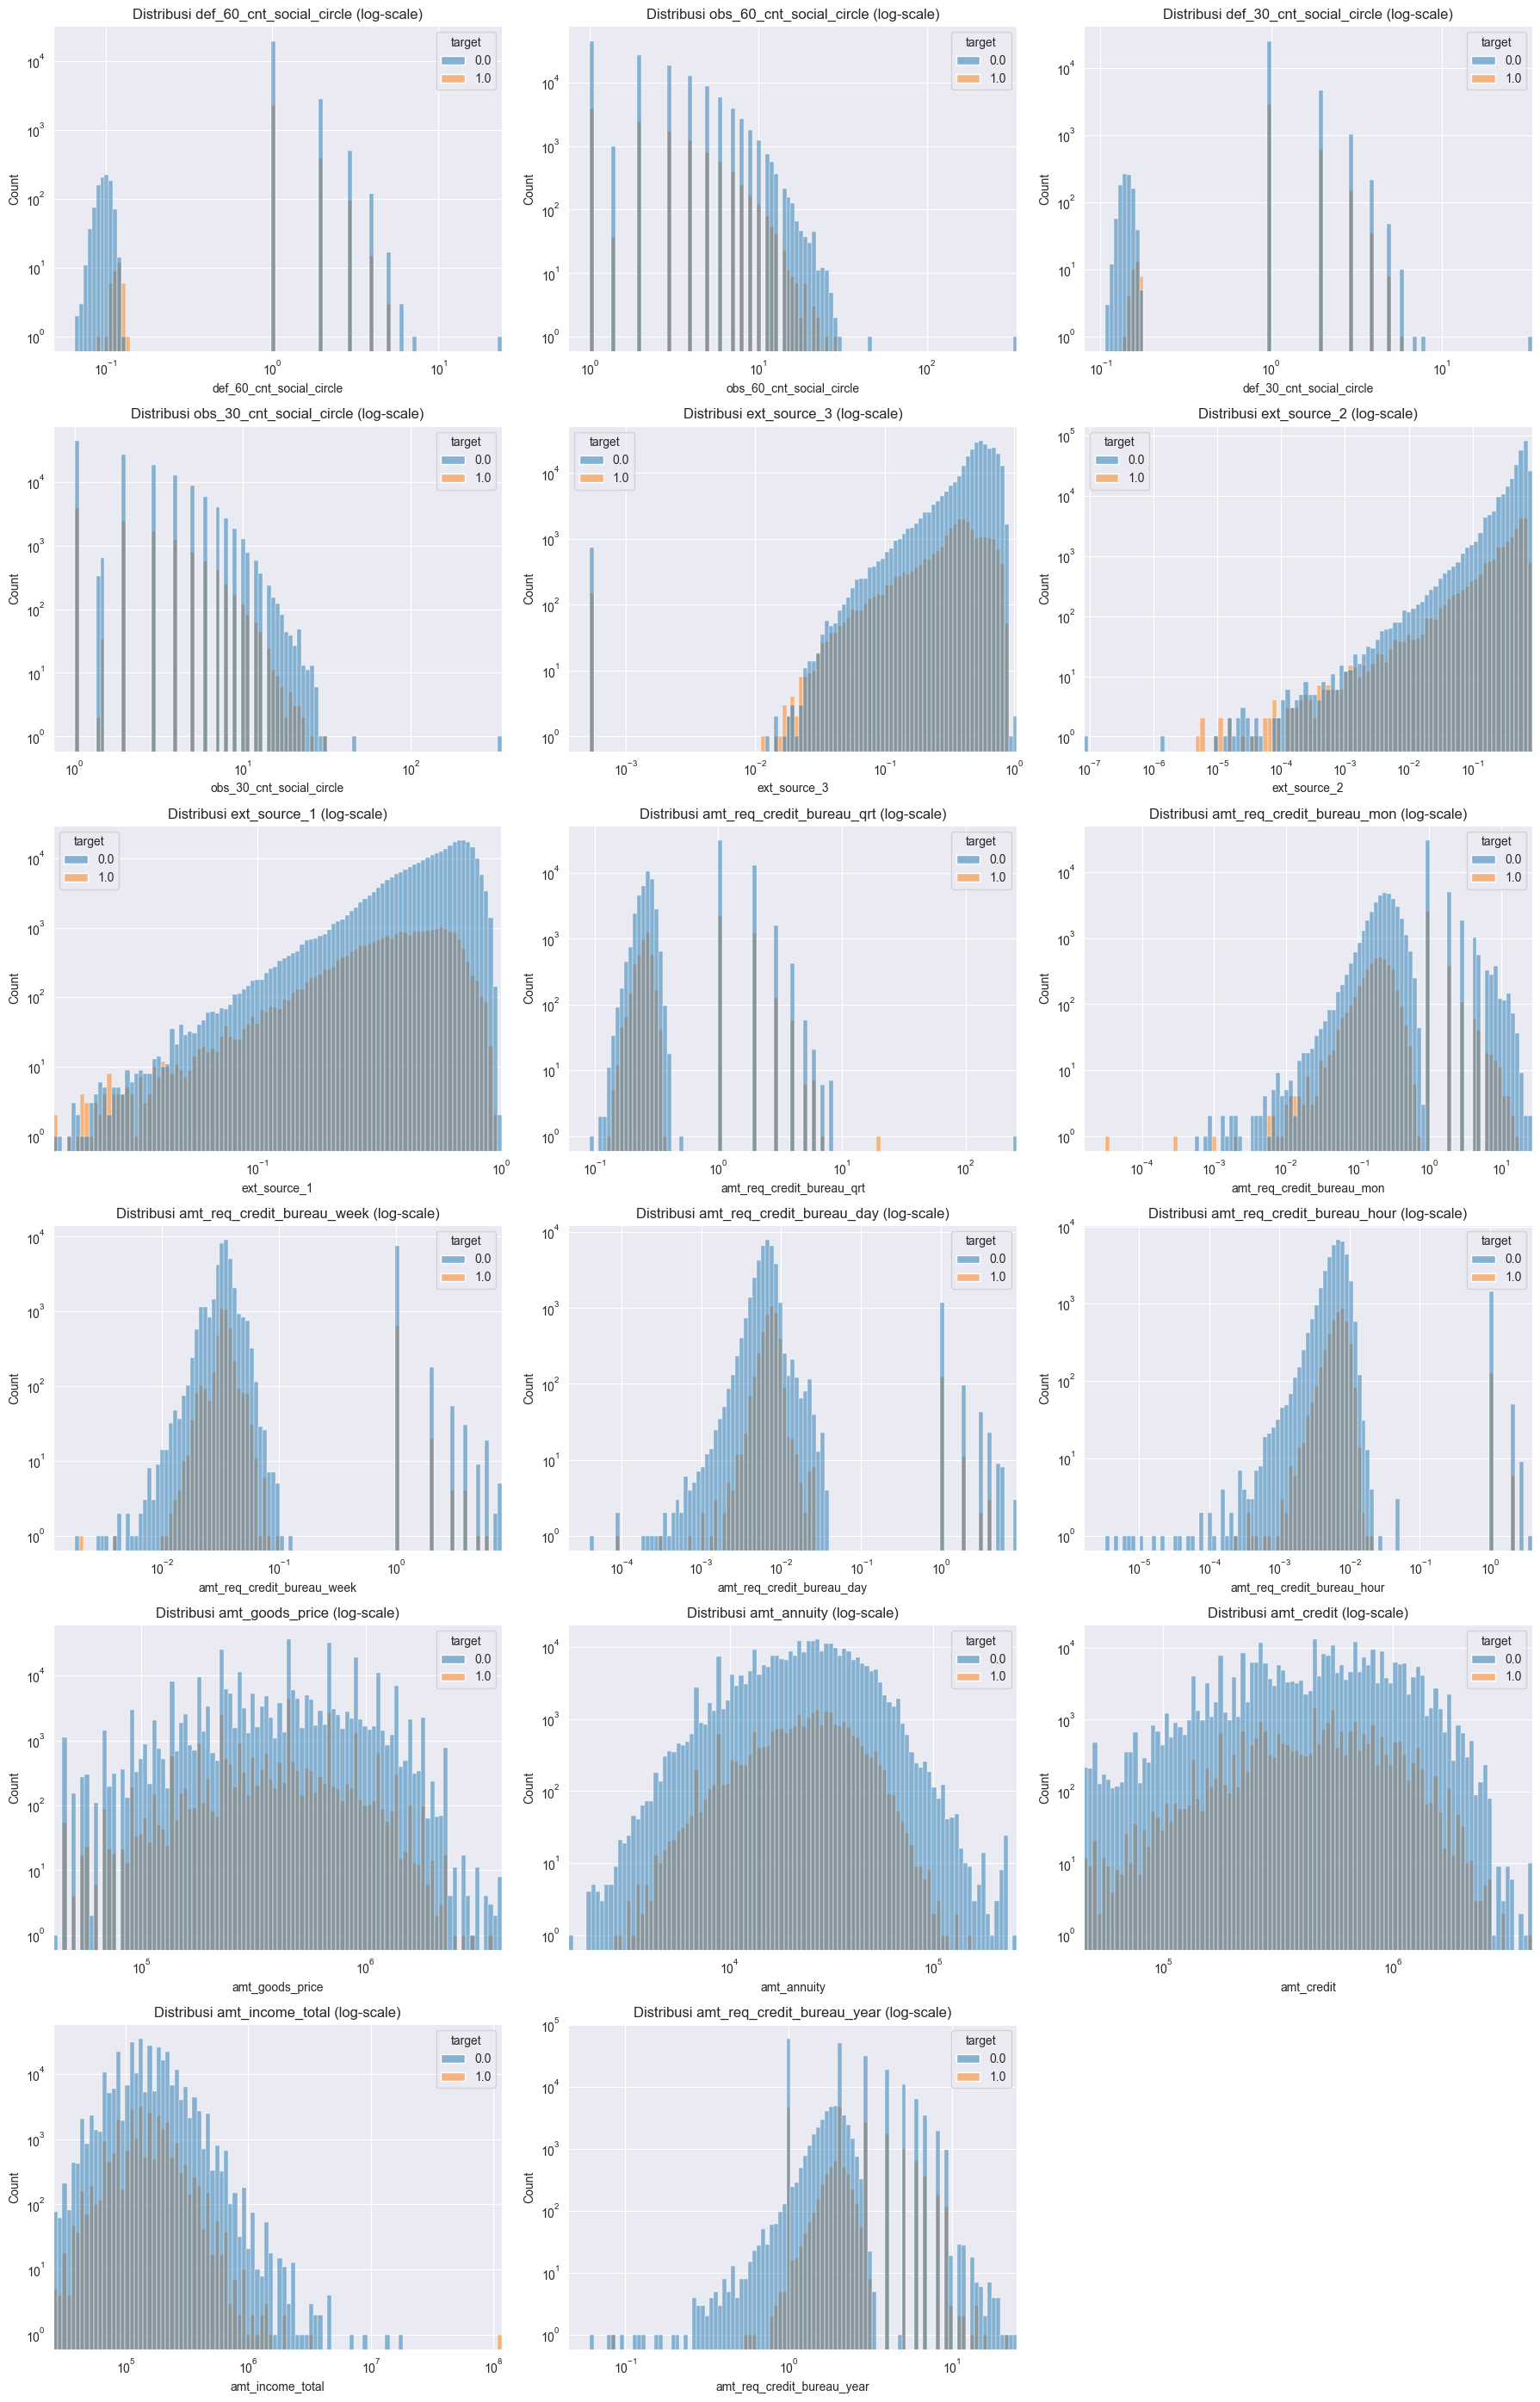

In [27]:
plt.figure(figsize=(18,28))
for i,col in enumerate(num_cont_cols):
    plt.subplot(6,3,(i+1))
    sns.histplot(train, x=col, bins=100, log_scale=True, hue='target')
    plt.title(f"Distribusi {col} (log-scale)")
    plt.xlim(train[col].min(), train[col].max())
    plt.yscale('log')

plt.tight_layout()
plt.show()

### <div style="color:white;display:fill;border-radius:8px;font-size:100%; letter-spacing:1.0px;"><p style="padding: 5px;color:white;text-align:left;"><b><span style='color:#FF0000'>1.2 Data Understanding & Cleaning Tabel Bureau & Bureau Balance</span></b></p></div>

- bureau.csv: Riwayat kredit sebelumnya dari biro kredit
- bureau_balance.csv: Riwayat bulanan kredit dari biro kredit

In [28]:
bureau = pd.read_csv(r"C:\Users\tamar\Downloads\home-credit-default-risk\bureau.csv")
display_data(bureau)

'Jumlah Baris: 1716428; Jumlah Kolom:17'

,sk_id_curr,sk_id_bureau,credit_active,credit_currency,days_credit,credit_day_overdue,days_credit_enddate,days_enddate_fact,amt_credit_max_overdue,cnt_credit_prolong,amt_credit_sum,amt_credit_sum_debt,amt_credit_sum_limit,amt_credit_sum_overdue,credit_type,days_credit_update,amt_annuity
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [29]:
bureau_meta = cek_data(bureau)
bureau_meta

,col,missings,missings_%,data_types,nuniques,uniques
16,amt_annuity,1226791,71.47,float64,40321,"[nan, 0.0, 2691.0, 24462.0, 8181.0, 8061.21, 1..."
8,amt_credit_max_overdue,1124488,65.51,float64,68251,"[nan, 77674.5, 0.0, 14985.0, 310.5, 20493.27, ..."
7,days_enddate_fact,633653,36.92,float64,2917,"[-153.0, nan, -1710.0, -840.0, -825.0, -187.0,..."
12,amt_credit_sum_limit,591780,34.48,float64,51726,"[nan, 108982.62, 0.0, 228320.1, 411.615, 12169..."
11,amt_credit_sum_debt,257669,15.01,float64,226537,"[0.0, 171342.0, nan, 71017.38, 42103.8, 76905...."
6,days_credit_enddate,105553,6.15,float64,14096,"[-153.0, 1075.0, 528.0, nan, 1197.0, 27460.0, ..."
10,amt_credit_sum,13,0.00,float64,236708,"[91323.0, 225000.0, 464323.5, 90000.0, 2700000..."
2,credit_active,0,0.00,object,4,"[Closed, Active, Sold, Bad debt]"
3,credit_currency,0,0.00,object,4,"[currency 1, currency 2, currency 4, currency 3]"
4,days_credit,0,0.00,int64,2923,"[-497, -208, -203, -629, -273, -43, -1896, -11..."


#### Statistik Deskriptif

In [30]:
round(bureau.describe(),1).T

,count,mean,std,min,25%,50%,75%,max
sk_id_curr,1716428.0,278214.9,102938.6,100001.0,188866.8,278055.0,367426.0,456255.0
sk_id_bureau,1716428.0,5924434.5,532265.7,5000000.0,5463953.8,5926303.5,6385681.2,6843457.0
days_credit,1716428.0,-1142.1,795.2,-2922.0,-1666.0,-987.0,-474.0,0.0
credit_day_overdue,1716428.0,0.8,36.5,0.0,0.0,0.0,0.0,2792.0
days_credit_enddate,1610875.0,510.5,4994.2,-42060.0,-1138.0,-330.0,474.0,31199.0
days_enddate_fact,1082775.0,-1017.4,714.0,-42023.0,-1489.0,-897.0,-425.0,0.0
amt_credit_max_overdue,591940.0,3825.4,206031.6,0.0,0.0,0.0,0.0,115987185.0
cnt_credit_prolong,1716428.0,0.0,0.1,0.0,0.0,0.0,0.0,9.0
amt_credit_sum,1716415.0,354994.6,1149811.3,0.0,51300.0,125518.5,315000.0,585000000.0
amt_credit_sum_debt,1458759.0,137085.1,677401.1,-4705600.3,0.0,0.0,40153.5,170100000.0


#### Catatan Singkat Penjelasan Kolom
- `amt_credit_max_overdue` : Jumlah tunggakan terbesar yang pernah terjadi pada kredit yang tercatat di biro. Sampai dengan tanggal pengajuan pinjaman dalam dataset kita (bukan nilai saat ini, tapi historis hingga waktu pengajuan)

- `days_credit`: Selisih waktu antara pengajuan kredit sebelumnya di biro dan permohonan pinjaman saat ini.

- `credit_day_overdue`: Berapa hari kredit di biro sudah melewati jatuh tempo (_past due_) saat pinjaman baru diajukan. Jika nilai positif, berarti ada tunggakan saat pinjaman baru tersebut dibuat. Jika nilainya nol atau negatif, berarti tidak ada tunggakan atau pembayarannya masih dalam periode yang wajar.

- `days_credit_enddate`: Jumlah hari yang tersisa sebelum kredit biro berakhir pada saat pengajuan aplikasi baru. Jika kredit sudah ditutup, nilainya nol atau negatif (artinya kredit sudah berakhir sebelum aplikasi diajukan).

- `days_enddate_fact`: Jumlah hari sejak kredit yang dilaporkan ke biro berakhir pada saat aplikasi baru diajukan (hanya berlaku untuk kredit yang sudah ditutup). Artinya, missing value pada kolom ini bisa jadi merupakan data kredit yang belum ditutup.

- `amt_credit_sum_limit`: Limit kartu kredit saat ini yang dilaporkan pada biro
- `amt_credit_sum_debt` : Jumlah utang yang masih harus dibayar oleh klien (saldo terutang)
- `amt_credit_sum` : Jumlah total kredit yang masih aktif (diberikan oleh lembaga keuangan). Total kredit yang masih berjalan, termasuk bagian yang belum digunakan.

    Perbedaan `amt_credit_sum` dan `amt_credit_sum_debt`: Misalkan seseorang memiliki kartu kredit dengan limit Rp10 juta, lalu ia telah menggunakan Rp4 juta, maka `amt_credit_sum` = Rp10 juta (karena ini adalah jumlah total kredit yang masih berlaku), dan `amt_credit_sum` = Rp4 juta (karena ini adalah jumlah yang harus dibayar kembali).

- `credit_active`: Status kredit yang dilaporkan pada biro (lunas dan ditutup, macet, aktif, dijual ke pihak lain)
- `credit_currency`: Mata uang kredit dalam laporan di biro
- `credit_day_overdue`: Jumlah hari keterlambatan pembayaran kredit di biro pada saat pengajuan pinjaman terkait dalam dataset kita
- `cnt_credit_prolong` : Frekuensi kredit biro diperpanjang
- `amt_credit_sum_overdue` : Jumlah uang yang terlambat dibayarkan hingga saat ini
- `days_credit_update`: Berapa hari sebelum pengajuan pinjaman, informasi terbaru tentang kredit di Credit Bureau diperbarui

#### Cek Data Anomali

In [31]:
# tidak diupdate selama 50 tahun
not_updated_anomalies = bureau[bureau['days_credit_update'] < -18250]

# cek data apakah data kredit yang tidak diupdate selama lebih dari 50 tahun memang dimiliki klien yang sangat tua
cek_credupdate_with_age = pd.merge(train[train['sk_id_curr'].isin(not_updated_anomalies['sk_id_curr'])][['sk_id_curr','days_birth']],
                                   bureau[['sk_id_curr','days_credit_update']],
                                   on='sk_id_curr')

cek_credupdate_with_age['is_anomalies'] = cek_credupdate_with_age.apply(
    lambda row: 1 if row['days_credit_update'] < row['days_birth'] else 0, axis=1
)

cek_credupdate_with_age['is_anomalies'].value_counts()

is_anomalies
0    1051
1      95
Name: count, dtype: int64

In [32]:
anomalies1 = cek_credupdate_with_age[cek_credupdate_with_age['is_anomalies'] == 1]

In [33]:
bureau = bureau[~bureau['sk_id_curr'].isin(anomalies1['sk_id_curr'])]

In [34]:
# hanya sertakan days_credit_enddate lebih dari 30 tahun sebelum permohonan/setelah permohonan
bureau = bureau[(bureau['days_credit_enddate'] >= -10950)]
bureau = bureau[(bureau['days_credit_enddate'] < 10950)]

In [35]:
# hanya sertakan data di mana amt_credit_sum >= amt_credit_sum_debt
bureau = bureau[bureau['amt_credit_sum'] >= bureau['amt_credit_sum_debt']]

In [36]:
# hanya sertakan data di mana days_enddate_fact kurang dari 30 tahun
bureau = bureau[bureau['days_enddate_fact'] >= -10950]

In [37]:
# ubah limit negatif menjadi nol
bureau.loc[bureau['amt_credit_sum_limit'] < 0, 'amt_credit_sum_limit'] = 0

In [38]:
bureau.describe().T

,count,mean,std,min,25%,50%,75%,max
sk_id_curr,868426.0,2.782396e+05,102903.100014,100001.000,1.889500e+05,278075.5,367437.00,456255.0
sk_id_bureau,868426.0,5.924737e+06,531634.320102,5000000.000,5.465013e+06,5927324.5,6384331.75,6843457.0
days_credit,868426.0,-1.398859e+03,760.783313,-2922.000,-1.966000e+03,-1293.0,-779.00,-4.0
credit_day_overdue,868426.0,2.717031e-01,22.689125,0.000,0.000000e+00,0.0,0.00,2792.0
days_credit_enddate,868426.0,-8.474264e+02,994.391320,-3985.000,-1.451000e+03,-787.0,-288.00,10936.0
days_enddate_fact,868426.0,-1.025062e+03,717.504981,-3042.000,-1.514000e+03,-889.0,-427.00,0.0
amt_credit_max_overdue,302515.0,2.544897e+03,45113.612511,0.000,0.000000e+00,0.0,0.00,13766418.0
cnt_credit_prolong,868426.0,2.248896e-03,0.052577,0.000,0.000000e+00,0.0,0.00,5.0
amt_credit_sum,868426.0,2.323587e+05,868067.324126,0.000,4.195916e+04,90000.0,210621.42,396000000.0
amt_credit_sum_debt,868426.0,3.056480e+03,96952.804307,-455190.525,0.000000e+00,0.0,0.00,51750000.0


#### Imputasi missing values

Setelah anomali dihapus, kolom-kolom yang memiliki proporsi missing value di atas 60% hanya = 'amt_annuity', 'amt_credit_max_overdue'. Kita hapus kedua kolom tersebut, dan menerapakan iterative imputer pada amt_credit_sum_limit:

In [39]:
cols_to_drop2 = ['amt_annuity', 'amt_credit_max_overdue']
bureau = bureau.drop(columns=cols_to_drop2)

In [40]:
bureau_num_cols = bureau.select_dtypes(include='number').columns
bureau[bureau_num_cols] = imputer.fit_transform(bureau[bureau_num_cols])

In [41]:
bureau_blnc = pd.read_csv(r"C:\Users\tamar\Downloads\home-credit-default-risk\bureau_balance.csv")
display_data(bureau_blnc)

'Jumlah Baris: 27299925; Jumlah Kolom:3'

,sk_id_bureau,months_balance,status
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


- `months_balance`: Jumlah bulan sejak tanggal laporan (dihitung mundur dari tanggal aplikasi kredit saat ini). Nilai negatif menunjukkan bulan-bulan sebelumnya.

- `status`: Status pembayaran kredit untuk bulan tersebut (kredit lancar, terlambat, bermasalah, dll)

    "C": Kredit ditutup (Closed).

    "0": Tidak ada keterlambatan (No delays).

    "1": Terlambat 1-29 hari.

    "2": Terlambat 30-59 hari.

    "3": Terlambat 60-89 hari.

    "4": Terlambat 90-119 hari.

    "5": Terlambat 120 hari atau lebih.

    "X": Tidak ada riwayat untuk bulan ini.

- Artinya, status "C, 0, dan X" bisa diberi label/ flag = "not late" dan status 1 sampai 5 sebagai "late"

#### Pivot table untuk mengetahui frekuensi keterlambatan per-id

In [42]:
status_pivot = bureau_blnc.pivot_table(index='sk_id_bureau',columns='status',aggfunc='size',fill_value=0)
status_pivot

status,0,1,2,3,4,5,C,X
sk_id_bureau,,,,,,,,
5001709,0,0,0,0,0,0,86,11
5001710,5,0,0,0,0,0,48,30
5001711,3,0,0,0,0,0,0,1
5001712,10,0,0,0,0,0,9,0
5001713,0,0,0,0,0,0,0,22
...,...,...,...,...,...,...,...,...
6842884,9,0,0,0,0,0,20,19
6842885,12,0,0,0,0,12,0,0
6842886,8,0,0,0,0,0,25,0


In [43]:
# hitung frekuensi keterlambatan per id
status_pivot['late_count'] = status_pivot.iloc[:,1:6].sum(axis=1)
status_pivot

status,0,1,2,3,4,5,C,X,late_count
sk_id_bureau,,,,,,,,,
5001709,0,0,0,0,0,0,86,11,0
5001710,5,0,0,0,0,0,48,30,0
5001711,3,0,0,0,0,0,0,1,0
5001712,10,0,0,0,0,0,9,0,0
5001713,0,0,0,0,0,0,0,22,0
...,...,...,...,...,...,...,...,...,...
6842884,9,0,0,0,0,0,20,19,0
6842885,12,0,0,0,0,12,0,0,12
6842886,8,0,0,0,0,0,25,0,0


In [44]:
status_pivot['flag_late'] = status_pivot['late_count'].apply(
    lambda row: 1 if row > 0 else 0
)
status_pivot

status,0,1,2,3,4,5,C,X,late_count,flag_late
sk_id_bureau,,,,,,,,,,
5001709,0,0,0,0,0,0,86,11,0,0
5001710,5,0,0,0,0,0,48,30,0,0
5001711,3,0,0,0,0,0,0,1,0,0
5001712,10,0,0,0,0,0,9,0,0,0
5001713,0,0,0,0,0,0,0,22,0,0
...,...,...,...,...,...,...,...,...,...,...
6842884,9,0,0,0,0,0,20,19,0,0
6842885,12,0,0,0,0,12,0,0,12,1
6842886,8,0,0,0,0,0,25,0,0,0


In [45]:
cek_data(bureau_blnc)

,col,missings,missings_%,data_types,nuniques,uniques
0,sk_id_bureau,0,0.0,int64,817395,"[5715448, 5715449, 5715451, 5715452, 5715453, ..."
1,months_balance,0,0.0,int64,97,"[0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -..."
2,status,0,0.0,object,8,"[C, 0, X, 1, 2, 3, 5, 4]"


### <div style="color:white;display:fill;border-radius:8px;font-size:100%; letter-spacing:1.0px;"><p style="padding: 5px;color:white;text-align:left;"><b><span style='color:#FF0000'>1.3 Data Understanding & Cleaning Tabel Previous Application</span></b></p></div>

In [46]:
prev_app = pd.read_csv(r"C:\Users\tamar\Downloads\home-credit-default-risk\previous_application.csv")
display_data(prev_app)

'Jumlah Baris: 1670214; Jumlah Kolom:37'

,sk_id_prev,sk_id_curr,name_contract_type,amt_annuity,amt_application,amt_credit,amt_down_payment,amt_goods_price,weekday_appr_process_start,hour_appr_process_start,flag_last_appl_per_contract,nflag_last_appl_in_day,rate_down_payment,rate_interest_primary,rate_interest_privileged,name_cash_loan_purpose,name_contract_status,days_decision,name_payment_type,code_reject_reason,name_type_suite,name_client_type,name_goods_category,name_portfolio,name_product_type,channel_type,sellerplace_area,name_seller_industry,cnt_payment,name_yield_group,product_combination,days_first_drawing,days_first_due,days_last_due_1st_version,days_last_due,days_termination,nflag_insured_on_approval
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
prev_app_meta = cek_data(prev_app)
prev_app_meta

,col,missings,missings_%,data_types,nuniques,uniques
14,rate_interest_privileged,1664263,99.64,float64,25,"[0.8673361522198731, nan, 0.8350951374207188, ..."
13,rate_interest_primary,1664263,99.64,float64,148,"[0.1828318032415278, nan, 0.1969143148588915, ..."
6,amt_down_payment,895844,53.64,float64,29278,"[0.0, nan, 12649.5, 1350.0, 9000.0, 13500.0, 4..."
12,rate_down_payment,895844,53.64,float64,207033,"[0.0, nan, 0.1039712869911545, 0.0513237940193..."
20,name_type_suite,820405,49.12,object,7,"[nan, Unaccompanied, Spouse, partner, Family, ..."
36,nflag_insured_on_approval,673065,40.30,float64,2,"[0.0, 1.0, nan]"
35,days_termination,673065,40.30,float64,2830,"[-37.0, 365243.0, -177.0, nan, -137.0, -334.0,..."
34,days_last_due,673065,40.30,float64,2873,"[-42.0, 365243.0, -182.0, nan, -144.0, -345.0,..."
33,days_last_due_1st_version,673065,40.30,float64,4605,"[300.0, 916.0, 59.0, -152.0, nan, -144.0, 885...."
32,days_first_due,673065,40.30,float64,2892,"[-42.0, -134.0, -271.0, -482.0, nan, -654.0, -..."


#### Statistik Deskriptif

In [48]:
round(prev_app.describe().T, 1)

,count,mean,std,min,25%,50%,75%,max
sk_id_prev,1670214.0,1923089.1,532598.0,1000001.0,1461857.2,1923110.5,2384279.8,2845382.0
sk_id_curr,1670214.0,278357.2,102814.8,100001.0,189329.0,278714.5,367514.0,456255.0
amt_annuity,1297979.0,15955.1,14782.1,0.0,6321.8,11250.0,20658.4,418058.1
amt_application,1670214.0,175233.9,292779.8,0.0,18720.0,71046.0,180360.0,6905160.0
amt_credit,1670213.0,196114.0,318574.6,0.0,24160.5,80541.0,216418.5,6905160.0
amt_down_payment,774370.0,6697.4,20921.5,-0.9,0.0,1638.0,7740.0,3060045.0
amt_goods_price,1284699.0,227847.3,315396.6,0.0,50841.0,112320.0,234000.0,6905160.0
hour_appr_process_start,1670214.0,12.5,3.3,0.0,10.0,12.0,15.0,23.0
nflag_last_appl_in_day,1670214.0,1.0,0.1,0.0,1.0,1.0,1.0,1.0
rate_down_payment,774370.0,0.1,0.1,-0.0,0.0,0.1,0.1,1.0


#### Catatan Singkat Penjelasan Kolom
1. Detail Pengajuan:

    - NAME_CONTRACT_TYPE: Jenis produk (Pinjaman Tunai, POS, dll.).
    - AMT_APPLICATION: Jumlah kredit yang diminta.
    - AMT_CREDIT: Jumlah kredit yang disetujui (bisa berbeda dengan yang diminta).
    - NAME_CONTRACT_STATUS: Status aplikasi (Disetujui/Ditolak/dll).

2. Parameter Keuangan:

    - AMT_ANNUITY: Pembayaran tahunan.
    - AMT_DOWN_PAYMENT: Uang muka.

3. Perilaku Peminjam:

    - DAYS_DECISION: Hari sejak keputusan aplikasi. (negatif)
    - CODE_REJECT_REASON: Alasan penolakan (jika ada).
    - CNT_PAYMENT: Jangka waktu kredit.

4. Konteks Pengajuan:
    - NAME_YIELD_GROUP: Kelompok suku bunga (Low/Medium/High).
    - CHANNEL_TYPE: Saluran akuisisi pelanggan.
    - NAME_GOODS_CATEGORY: Kategori barang (untuk pinjaman POS).

#### Cek Data Anomali

Pertama-tama hapus dulu dua kolom dengan missing value di atas 90%

In [49]:
cols_to_drop3 = prev_app_meta[prev_app_meta['missings_%'] > 90]['col'].values
prev_app = prev_app.drop(columns=cols_to_drop3)

In [50]:
# hanya sertakan data di mana dp selalu lebih kecil dari amount kredit
prev_app = prev_app[prev_app['amt_credit'] > prev_app['amt_down_payment']]

In [51]:
prev_app['name_contract_status'].value_counts()

name_contract_status
Approved        657793
Refused          86952
Unused offer     23994
Canceled           633
Name: count, dtype: int64

In [52]:
cek_data(prev_app)

,col,missings,missings_%,data_types,nuniques,uniques
18,name_type_suite,274976,35.74,object,7,"[nan, Unaccompanied, Family, Spouse, partner, ..."
34,nflag_insured_on_approval,124890,16.23,float64,2,"[0.0, 1.0, nan]"
33,days_termination,124890,16.23,float64,2826,"[-37.0, -163.0, -627.0, -512.0, -1226.0, -1334..."
32,days_last_due,124890,16.23,float64,2870,"[-42.0, -168.0, -633.0, -518.0, -1230.0, -1343..."
31,days_last_due_1st_version,124890,16.23,float64,3853,"[300.0, -168.0, -633.0, -518.0, -1230.0, -1343..."
30,days_first_due,124890,16.23,float64,2892,"[-42.0, -378.0, -693.0, -668.0, -1440.0, -1853..."
29,days_first_drawing,124890,16.23,float64,526,"[365243.0, nan, -406.0, -2426.0, -297.0, -2198..."
3,amt_annuity,33389,4.34,float64,312604,"[1730.43, 7654.86, 9644.22, 21307.455, 4187.34..."
26,cnt_payment,33385,4.34,float64,41,"[12.0, 8.0, 3.0, 6.0, 18.0, nan, 24.0, 10.0, 4..."
23,channel_type,0,0.00,object,7,"[Country-wide, Stone, Regional / Local, Credit..."


In [53]:
missing_mask = prev_app[['days_first_drawing',
                         'days_first_due',
                         'days_last_due_1st_version',
                         'days_last_due',
                         'days_termination',
                         'nflag_insured_on_approval']].isnull()
prev_app['is_missing'] = missing_mask.any(axis=1)
print(prev_app.groupby('name_contract_status')['is_missing'].mean())

name_contract_status
Approved        0.020236
Canceled        1.000000
Refused         1.000000
Unused offer    1.000000
Name: is_missing, dtype: float64


- Hanya 2% permohonan yang disetujui memiliki missing value di kolom tahap akhir. Ini wajar (mungkin kesalahan input data).
- Semua permohonan yang dibatalkan/ditolak/tidak digunakan memiliki missing value di kolom terkait pencairan/jatuh tempo.

In [54]:
# kolom flag untuk data approved
prev_app['is_approved'] = (prev_app['name_contract_status'] == 'Approved').astype(int)

In [55]:
approved_with_missing = prev_app[
    (prev_app['name_contract_status'] == 'Approved') & 
    (prev_app['is_missing'])
]

In [56]:
# jumlah pinjaman aktif di institusi pinjaman lain (dari tabel bureau)
active_loans = bureau[bureau['credit_active'] == 'Active'].groupby('sk_id_curr').size()
prev_app['num_active_loans'] = prev_app['sk_id_curr'].map(active_loans).fillna(0)

In [57]:
# jumlah riwayat pinjaman di Home Credit
cnt_prev_loan = prev_app.groupby('sk_id_curr')['sk_id_prev'].count()
prev_app['cnt_prev_loan'] = prev_app['sk_id_curr'].map(cnt_prev_loan).fillna(0)

## 2. Business Insight 1

In [58]:
# Ambil data 12 bulan terakhir
bureau_blnc['is_recent'] = bureau_blnc['months_balance'].between(-12, -1)
recent_data = bureau_blnc[bureau_blnc['is_recent']].copy()

In [59]:
def categorize_trend(group):
    early_statuses = group.loc[group['months_balance'].between(-12, -6), 'status']
    latest_statuses = group.loc[group['months_balance'].between(-6, -1), 'status']
    
    if early_statuses.empty or latest_statuses.empty:
        return "not analyzed"
    
    # Hitung % status "0" di periode terbaru
    pct_on_time = (latest_statuses == "0").mean()
    # Hitung frekuensi keterlambatan di periode awal
    early_delays = early_statuses.isin(["1", "2", "3", "4", "5"]).sum()
    
    if (early_delays >= 3) and (pct_on_time >= 0.8):  # Minimal 80% pembayaran tepat waktu
        return "improved"
    elif (early_delays >= 3) and (pct_on_time < 0.5):
        return "deteriorated"
    else:
        return "not improved"

# Terapkan fungsi pada setiap grup SK_ID_BUREAU
client_trends = recent_data.groupby('sk_id_bureau').apply(categorize_trend).reset_index()
client_trends.columns = ['sk_id_bureau', 'payment_trend']

print(client_trends['payment_trend'].value_counts())  # Lihat distribusi kategori
print(client_trends)

payment_trend
not improved    590972
not analyzed     82703
deteriorated      2723
improved           582
Name: count, dtype: int64
        sk_id_bureau payment_trend
0            5001709  not improved
1            5001710  not improved
2            5001711  not analyzed
3            5001712  not improved
4            5001713  not improved
...              ...           ...
676975       6842884  not improved
676976       6842885  deteriorated
676977       6842886  not improved
676978       6842887  not improved
676979       6842888  not improved

[676980 rows x 2 columns]


In [60]:
improved_clients = client_trends[client_trends['payment_trend'] == 'improved']
deteriorated_clients = client_trends[client_trends['payment_trend'] == 'deteriorated']
not_improved_clients = client_trends[client_trends['payment_trend'] == 'not improved']

In [61]:
refused_app = prev_app[(prev_app['name_contract_status']=='Refused')&(prev_app['code_reject_reason'].isin(["HCI","SCO","LIMIT"]))]

In [62]:
refused_client = pd.merge(refused_app[['sk_id_curr',
                                       'name_contract_status',
                                       'code_reject_reason']],
                        bureau[['sk_id_curr','sk_id_bureau']],
                        on='sk_id_curr')

In [63]:
refused_client_target = pd.merge(refused_client, train[['sk_id_curr','target']], on='sk_id_curr')
refused_client_target 

,sk_id_curr,name_contract_status,code_reject_reason,sk_id_bureau,target
0,178375,Refused,LIMIT,6662981.0,0.0
1,372945,Refused,SCO,5544398.0,0.0
2,372945,Refused,SCO,5544399.0,0.0
3,372945,Refused,SCO,5544404.0,0.0
4,372945,Refused,SCO,5544405.0,0.0
...,...,...,...,...,...
153326,213646,Refused,LIMIT,5059653.0,0.0
153327,443544,Refused,SCO,5255526.0,0.0
153328,443544,Refused,SCO,5255527.0,0.0
153329,443544,Refused,SCO,5255528.0,0.0


In [64]:
refused_client_target = pd.merge(refused_client_target, client_trends[['sk_id_bureau','payment_trend']], on='sk_id_bureau')

In [65]:
approved_app = prev_app[(prev_app['name_contract_status']=='Approved')]
approved_client = pd.merge(approved_app[['sk_id_curr',
                                         'name_contract_status',
                                         'code_reject_reason']],
                           bureau[['sk_id_curr','sk_id_bureau']], on='sk_id_curr')

approved_client_target = pd.merge(approved_client, train[['sk_id_curr','target']], on='sk_id_curr')
approved_client_target

,sk_id_curr,name_contract_status,code_reject_reason,sk_id_bureau,target
0,271877,Approved,XAP,6051773.0,0.0
1,271877,Approved,XAP,6051774.0,0.0
2,154602,Approved,XAP,5414631.0,0.0
3,418383,Approved,XAP,6627422.0,0.0
4,170289,Approved,XAP,6664990.0,0.0
...,...,...,...,...,...
1582575,249544,Approved,XAP,5031203.0,0.0
1582576,249544,Approved,XAP,5031204.0,0.0
1582577,249544,Approved,XAP,5031205.0,0.0
1582578,249544,Approved,XAP,5031193.0,0.0


In [66]:
approved_client_target = pd.merge(approved_client_target, client_trends[['sk_id_bureau','payment_trend']], on='sk_id_bureau')

In [67]:
# fungsi membuat stacked plot batang
def stacked_plot(table, title, x_label, y_label, legend):
    plt.figure(figsize=(8,5))
    ax= table.plot(kind='bar', stacked=True, colormap="coolwarm", ax=plt.gca())

    ax.set_title(f"{title}", size=15, weight="bold", color='darkred', fontfamily = 'Georgia')
    ax.set_xlabel(x_label, fontdict={'fontsize':12,
                                            'color':'darkblue',
                                            'fontfamily':'Georgia'})
    ax.set_ylabel(y_label)
    ax.legend(title=legend)
    plt.xticks(fontsize = 10, rotation = 0)

    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x = p.get_x() + width / 2
        y = p.get_y() + height / 2

        # Tampilkan persentase jika tinggi batang lebih dari 0
        if height > 0:
            ax.text(x, y, f"{height:.1%}", ha="center", va="center", color="white", weight="bold", fontfamily="Georgia")

In [68]:
refused_default_rate = refused_client_target.groupby('payment_trend')['target'].value_counts(normalize=True).unstack()
refused_default_rate.columns = ["Not Default","Default"]
refused_default_rate

,Not Default,Default
payment_trend,,
deteriorated,0.785901,0.214099
improved,0.958333,0.041667
not analyzed,0.877953,0.122047
not improved,0.916835,0.083165


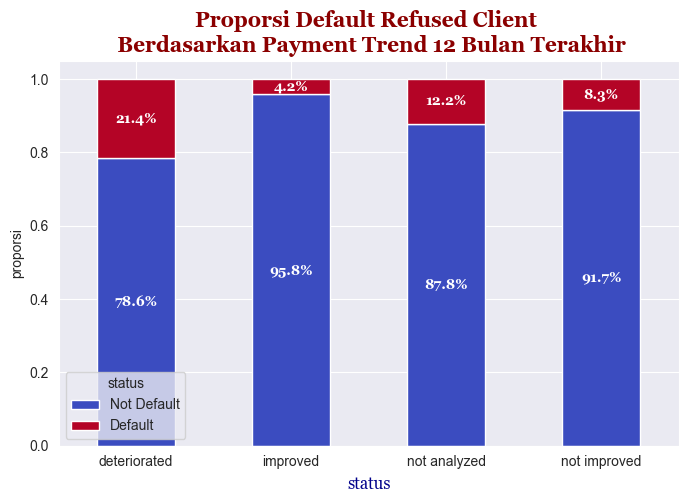

In [69]:
stacked_plot(refused_default_rate, "Proporsi Default Refused Client \n Berdasarkan Payment Trend 12 Bulan Terakhir",
             "status","proporsi","status")

In [70]:
approved_default_rate = approved_client_target.groupby('payment_trend')['target'].value_counts(normalize=True).unstack()
approved_default_rate.columns = ["Not Default","Default"]
approved_default_rate

,Not Default,Default
payment_trend,,
deteriorated,0.887182,0.112818
improved,0.929368,0.070632
not analyzed,0.909142,0.090858
not improved,0.933501,0.066499


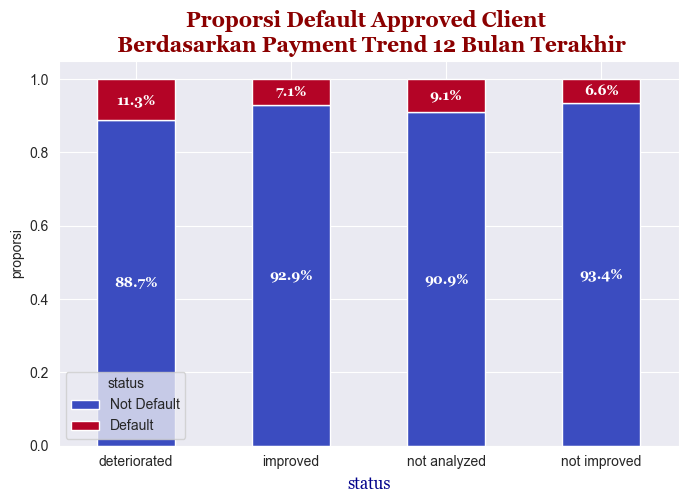

In [71]:
stacked_plot(approved_default_rate, "Proporsi Default Approved Client \n Berdasarkan Payment Trend 12 Bulan Terakhir",
             "status","proporsi","status")

**Actionable Insight:**

Peminjam yang menunjukkan pola perbaikan dalam riwayat pembayaran (dari status terlambat menjadi lancar) selama 12 bulan terakhir, namun sebelumnya `pernah ditolak oleh Home Credit` karena catatan historis (risiko kredit tinggi, melebihi batas kredit, dan skor kredit rendah), ternyata memiliki tingkat default yang:

- 7.1% lebih rendah dibandingkan dengan peminjam yang disetujui (approved client) tetapi mengalami penurunan performa pembayaran dalam periode yang sama.
- 3% lebih rendah dibandingkan dengan peminjam yang disetujui dan juga menunjukkan peningkatan performa pembayaran.

Sementara, peminjam yang riwayat pembayarannya memburuk (dari lancar menjadi terlambat) selama 12 bulan terakhir, baik yang pernah ditolak maupun yang diloloskan HCI, memiliki tingkat default 5 kali lipat lebih tinggi dibandingkan segmen di atas (default rate hingga 21%).

**Solusi yang Dapat Dipertimbangkan:**

1. Program "Second Chance" untuk Peminjam dengan Tren Membaik (_Improved_)

    Target: Peminjam yang pernah ditolak (karena risiko historis) tetapi telah menunjukkan perbaikan konsisten selama 12 bulan terakhir.
    Tawarkan restrukturisasi utang atau kredit baru dengan limit moderat:
    - Bunga lebih rendah daripada produk reguler (misalnya, 10-15% vs 20%+), tetapi tetap profitable.
    - Batas kredit awal 50-70% dari standar untuk mitigasi risiko.

    Syarat khusus:
    - Wajib memiliki ≥80% pembayaran tepat waktu dalam 6-12 bulan terakhir.
    - Berikan opsi pembayaran fleksibel (grace period 7 hari tanpa denda).

    Potensi manfaat:
    - Menjaring peminjam berkualitas yang sebelumnya terlewat (default rate 7-3% lebih rendah).
    - Meningkatkan loyalitas pelanggan ("reward" untuk perilaku baik).

2. Pemantauan Ketat untuk Peminjam dengan Tren Memburuk (_Deteriorated_)

    Target: Semua peminjam (baik yang baru/lama) dengan riwayat pembayaran memburuk dalam 12 bulan terakhir (default rate 5× lebih tinggi!).
    Terapkan early warning system:
    - Otomatis turunkan limit kredit jika ada ≥2 keterlambatan dalam 3 bulan.
    - Blokir akses ke pinjaman tambahan sampai performa membaik.

    Pencegahan:
    Tawarkan konsolidasi utang (jika banyak kredit aktif) dengan syarat:
    - Bunga tetap (non-compounding).
    - Tenor diperpanjang untuk turunkan cicilan bulanan.

    Exit strategy:
    - Jika tidak ada perbaikan dalam 6 bulan, alihkan ke tim koleksi atau jual portofolio utang.

3. Optimasi Kebijakan Persetujuan Kredit

    - Kurangi bobot data historis untuk peminjam yang sudah menunjukkan perbaikan ≥12 bulan.
    - Tambahkan parameter tren pembayaran dalam scoring model:
        - Beri bobot 30-40% untuk perilaku terbaru (6-12 bulan), bukan hanya riwayat 5 tahun lalu.

    Potensi Manfaat: Menghindari false negative (menolak peminjam potensial yang sudah membaik).

4. Produk Hybrid untuk Peminjam "Abu-abu" (_Not Improved_)
    Target: Peminjam dengan tren stabil (tidak membaik/memburuk) atau fluktuatif.
    Kredit mikro dengan fitur "upgrade":
    - Limit awal kecil (Rp 1-5 juta), jika lancar 6 bulan → naikkan limit secara otomatis.
    - Bunga tiered (misalnya: 12% bulan 1-6, turun jadi 9% setelah 6 bulan lancar).

Implementasi Bertahap
1. Pilot Project (3-6 bulan):
    Uji coba di 1-2 cabang dengan segmentasi jelas (misalnya: 100 peminjam "second chance").

2. Evaluasi:
    Bandingkan default rate, NPL, dan ROI dengan kelompok kontrol.

3. Scale-Up:
    Ekspansi ke seluruh jaringan jika hasil pilot menunjukkan:
    - Penurunan default rate ≥5%.
    - Peningkatan persetujuan kredit tanpa tambahan risiko signifikan.

## 3. Business Insight 2

- Dari informasi tabel train, bureau, dan bureau_balance

In [72]:
# low credit adalah jumlah pinjaman di bawah threshold Q3
lower_credit = bureau[bureau['amt_credit_sum'] <= bureau['amt_credit_sum'].quantile(0.75)]
higher_credit = bureau[bureau['amt_credit_sum'] > bureau['amt_credit_sum'].quantile(0.75)]

In [73]:
lower_cred_high_limit = lower_credit[lower_credit['amt_credit_sum_limit'] > lower_credit['amt_credit_sum_limit'].quantile(0.75)]
lower_cred_low_limit = lower_credit[lower_credit['amt_credit_sum_limit'] <= lower_credit['amt_credit_sum_limit'].quantile(0.75)]

higher_cred_high_limit = higher_credit[higher_credit['amt_credit_sum_limit'] > higher_credit['amt_credit_sum_limit'].quantile(0.75)]
higher_cred_low_limit = higher_credit[higher_credit['amt_credit_sum_limit'] <= higher_credit['amt_credit_sum_limit'].quantile(0.75)]

In [74]:
thresh = bureau['amt_credit_sum'].quantile(0.75)

bureau['name_amt_cred'] = bureau['amt_credit_sum'].apply(
    lambda x: 'lower credit' if x <= thresh else 'higher credit'
)

In [75]:
bureau['name_amt_cred'].value_counts(normalize=True)

name_amt_cred
lower credit     0.749999
higher credit    0.250001
Name: proportion, dtype: float64

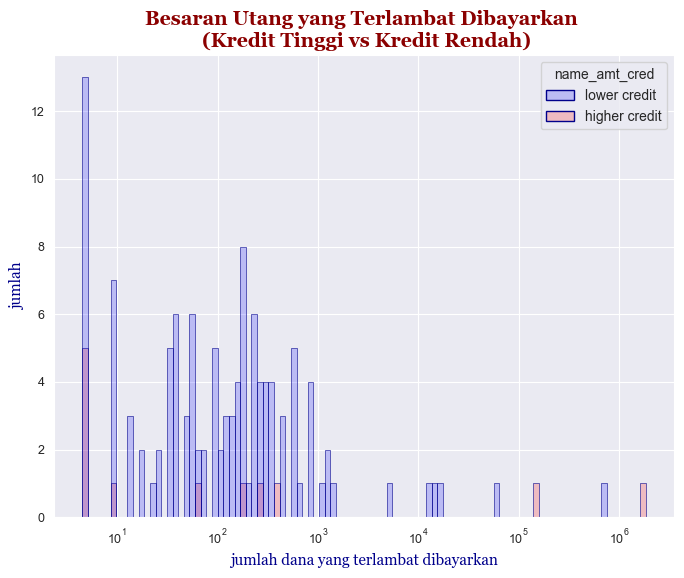

In [76]:
custom_palette = ["blue", "red"]

plt.figure(figsize=(8,6))
sns.set_style('darkgrid')
sns.histplot(bureau, x='amt_credit_sum_overdue', hue='name_amt_cred', bins=100,
             log_scale=True,
             palette=custom_palette, edgecolor='darkblue', alpha=0.2)

plt.xlabel("jumlah dana yang terlambat dibayarkan",
           fontdict={'fontsize':11,
                     'color':'darkblue',
                     'fontfamily':'Georgia'})
plt.ylabel("jumlah",
           fontdict={'fontsize':11,
                     'color':'darkblue',
                     'fontfamily':'Georgia'})
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.title("Besaran Utang yang Terlambat Dibayarkan \n (Kredit Tinggi vs Kredit Rendah)",
          fontdict={'fontsize':14,
                    'color':'darkred',
                    'fontweight':'bold',
                    'fontfamily':'Georgia'})
plt.show()

In [77]:
lower_delay_mean = lower_credit['amt_credit_sum_overdue'].mean()
higher_delay_mean = higher_credit['amt_credit_sum_overdue'].mean()

print(f"Lower Credit - Mean: {lower_delay_mean}")
print(f"Higher Credit - Mean: {higher_delay_mean}")
print(f"Rata-rata uang yang terlambat dibayarkan oleh peminjam tingkat rendah {((higher_delay_mean-lower_delay_mean)/higher_delay_mean)*100} % lebih rendah")

Lower Credit - Mean: 1.31640450378386
Higher Credit - Mean: 9.257119761223729
Rata-rata uang yang terlambat dibayarkan oleh peminjam tingkat rendah 85.77954549861154 % lebih rendah


In [78]:
bureau.loc[bureau['sk_id_curr'].isin(lower_cred_low_limit['sk_id_curr']), 'name_amt_limit_cred'] = 'lower credit low limit'
bureau.loc[bureau['sk_id_curr'].isin(lower_cred_high_limit['sk_id_curr']), 'name_amt_limit_cred'] = 'lower credit high limit'

bureau.loc[bureau['sk_id_curr'].isin(higher_cred_low_limit['sk_id_curr']), 'name_amt_limit_cred'] = 'higher credit low limit'
bureau.loc[bureau['sk_id_curr'].isin(higher_cred_high_limit['sk_id_curr']), 'name_amt_limit_cred'] = 'higher credit high limit'

In [79]:
bureau_merged = pd.merge(status_pivot, bureau[['sk_id_bureau',
                                               'amt_credit_sum',
                                               'amt_credit_sum_limit',
                                               'name_amt_cred',
                                               'name_amt_limit_cred']], on='sk_id_bureau', how='inner')
bureau_merged

,sk_id_bureau,0,1,2,3,4,5,C,X,late_count,flag_late,amt_credit_sum,amt_credit_sum_limit,name_amt_cred,name_amt_limit_cred
0,5001710,5,0,0,0,0,0,48,30,0,0,450000.00,0.000000,higher credit,higher credit low limit
1,5001712,10,0,0,0,0,0,9,0,0,0,138388.50,0.000000,lower credit,higher credit low limit
2,5001713,0,0,0,0,0,0,0,22,0,0,104922.18,1305.121858,lower credit,lower credit high limit
3,5001714,0,0,0,0,0,0,0,15,0,0,52596.00,1025.835368,lower credit,lower credit high limit
4,5001715,0,0,0,0,0,0,0,60,0,0,47155.50,0.000000,lower credit,higher credit low limit
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393318,6842884,9,0,0,0,0,0,20,19,0,0,135000.00,2447.742061,lower credit,higher credit low limit
393319,6842885,12,0,0,0,0,12,0,0,12,1,461729.07,0.000000,higher credit,higher credit low limit
393320,6842886,8,0,0,0,0,0,25,0,0,0,108000.00,0.000000,lower credit,higher credit low limit
393321,6842887,6,0,0,0,0,0,31,0,0,0,67500.00,0.000000,lower credit,higher credit low limit


In [80]:
late_prcntg = bureau_merged.groupby('name_amt_cred')['flag_late'].value_counts(normalize=True).unstack()
late_prcntg.columns = ["not late", "late"]
late_prcntg

,not late,late
name_amt_cred,,
higher credit,0.856752,0.143248
lower credit,0.889536,0.110464


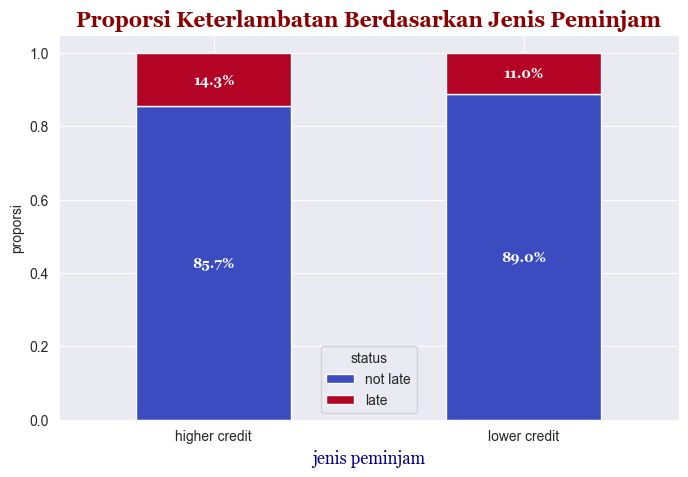

In [81]:
stacked_plot(late_prcntg,"Proporsi Keterlambatan Berdasarkan Jenis Peminjam","jenis peminjam", "proporsi", "status")

In [82]:
bureau_target_merged = pd.merge(train[['sk_id_curr','target']], bureau, how='inner', on='sk_id_curr')

In [83]:
dflt_prcntg_1 = bureau_target_merged.groupby('name_amt_cred')['target'].value_counts(normalize=True).unstack()
dflt_prcntg_1.columns = ["not_default","default"]
dflt_prcntg_1

,not_default,default
name_amt_cred,,
higher credit,0.934858,0.065142
lower credit,0.928284,0.071716


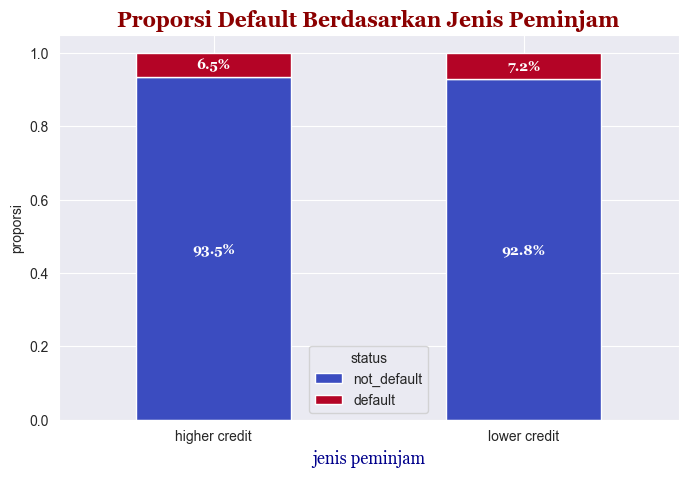

In [84]:
stacked_plot(dflt_prcntg_1, "Proporsi Default Berdasarkan Jenis Peminjam", "jenis peminjam", "proporsi", "status")

- Sekilas secara keseluruhan, peminjam dengan utang rendah sedikit lebih sering default. Namun, mengingat proporsi peminjam tingkat rendah jauh lebih banyak (76%) dibandingkan peminjam utang tinggi (24%). Maka saya menyelidiki fitur lain, yaitu limit kredit yang diberikan. Perhatikan visualisasi di bawah ini:

In [85]:
dflt_prcntg = bureau_target_merged.groupby('name_amt_limit_cred')['target'].value_counts(normalize=True).unstack()
dflt_prcntg.columns = ["not_default","default"]
dflt_prcntg

,not_default,default
name_amt_limit_cred,,
higher credit high limit,0.930070,0.069930
higher credit low limit,0.934465,0.065535
lower credit high limit,0.923220,0.076780
lower credit low limit,0.927240,0.072760


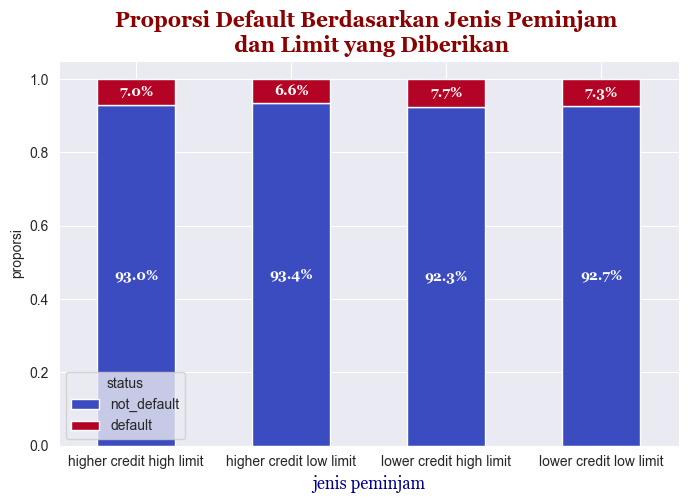

In [86]:
stacked_plot(dflt_prcntg, "Proporsi Default Berdasarkan Jenis Peminjam \n dan Limit yang Diberikan", "jenis peminjam", "proporsi", "status")

**Actionable Insight:**
Jumlah peminjam dengan tingkat utang rendah (low credit) lebih banyak (75%) dibandingkan peminjam dengan tingkat utang tinggi (25%), tetapi `rata-rata sisa hutang yang terlambat dibayarkannya 85,8% lebih kecil dan riwayat terlambat bayarnya 3,3% lebih rendah` dibandingkan pelanggan dengan tingkat utang tinggi. Namun, `proporsi default-nya lebih besar 0,4% ketika diberikan limit kredit tinggi`. Oleh karena itu:
- segmen pelanggan dengan proporsi default paling rendah adalah peminjam utang tinggi dengan limit kredit rendah (6,6%), dan
- segmen pelanggan dengan default paling tinggi adalah peminjam tingkat utang rendah dengan limit kredit tinggi (7,7%).


**Solusi yang bisa dipertimbangkan:**
1. Segmentasi Pelanggan & Penyesuaian Limit Kredit

    `Utang Rendah + Limit Tinggi` (Default 7.7%) => Terapkan "Limit Shield": Otomatis turun 10% jika misalnya utilisasi kredit >70% selama 3 bulan berturut-turut. Kita bisa mengurangi risiko akumulasi utang tanpa kehilangan banyak pelanggan profitable, sebab peminjam utang rendah proporsinya sangat dominan.

    `Utang Tinggi + Limit Rendah` (Default 6.6%) => Pertahankan limit, tapi berikan opsi konversi utang ke produk refinancing dengan tenor lebih panjang. Manfaatkan profil risiko rendah mereka untuk retensi dengan produk lebih stabil.

2. Restrukrisasi Cicilan
    
    Mengingat peminjam utang tinggi adalah yang paling sering terlambat bayar, tawarkan opsi Flexi-Payment yaitu pembayaran minimum 20-30% dari cicilan normal untuk 3 bulan pertama, dengan syarat:
    - Pelanggan menyetujui auto-debit setelah periode flexi.
    - Bunga tambahan 0.5% p.a. selama masa flexi.

3. Dynamic Credit Scoring
    
    Gunakan model real-time untuk menyesuaikan limit kredit berdasarkan:
    - Riwayat pembayaran (contohnya: status per bulan dalam data bureau_balance).
    - Perubahan utilisasi kartu kredit (credit_utilization).

4. A/B Testing Strategi
    
    | **Grup** | **Intervensi** | **Metric yang Diukur** |
    |----------|--------------|-------------------------|
    | **Grup A: Utang Tinggi + Limit Turun 20%** | - Batasi limit via sistem. <br> - Berikan notifikasi: "Limit Anda disesuaikan untuk memaksimalkan kesehatan kredit." | Default rate, utilisasi kredit, retensi pelanggan. |
    | **Grup B: Utang Tinggi + Limit Tetap** | - Pertahankan limit. <br> - Tambahkan alert: "Anda mendekati batas aman utilisasi kredit." | Perbandingan dengan Grup A. |
    **Hypothesis** : **Grup A akan menunjukkan penurunan default rate 1.2-1.8% dalam 6 bulan.**

    **Eksperimen lainnya:**

    Kelompok A: Peminjam utang rendah diberi limit 25% lebih rendah dari standar.

    Kelompok B: Peminjam utang tinggi diberi opsi konversi utang ke tenor lebih panjang.

    Metric: Bandingkan tingkat default dan profitabilitas setelah 6 bulan.

## Feature Engineering

### 1. flag_document_sum
- Untuk kolom flag document, saya akan membuat kolom baru berupa hasil penjumlahan dari seluruh dokumen flag (`flag_document_sum`). Kemudian, menghapus seluruh flag_document

In [87]:
flag_document_cols = train.columns[train.columns.str.contains('flag_document_')]
train['flag_document_sum'] = train.loc[:, flag_document_cols].sum(axis=1)
test['flag_document_sum'] = test.loc[:, flag_document_cols].sum(axis=1)

In [88]:
train = train.drop(columns=flag_document_cols)
test = test.drop(columns=flag_document_cols)

### 2. total_ext_source

Sama seperti kolom-kolom flag_document, kolom-kolom ext_source juga akan saya jumlahkan ke dalam kolom baru bernama `total_ext_source`.

In [89]:
ext_source_cols = train.columns[train.columns.str.contains('ext_source')]
train['total_ext_source'] = train.loc[:, ext_source_cols].sum(axis=1)
test['total_ext_source'] = test.loc[:, ext_source_cols].sum(axis=1)

In [90]:
train = train.drop(columns=ext_source_cols)
test = test.drop(columns=ext_source_cols)

### 3. Penyesuaian fitur `amt_req_credit_bureau` menjadi dua kelompok
Untuk kolom-kolom tentang informasi frekuensi permintaan laporan kredit klien ke biro (`amt_req_credit_bureau`) yang dipisah2 menurut waktunya, saya akan membuat kolom kombinasi, yaitu:
- `short_term_req`: Total permintaan jangka pendek (jam, hari, minggu)
- `long_term_req`: Total permintaan jangka panjang (bulan, kuartal, tahun)

In [91]:
amt_req_credbureau_cols = train.columns[train.columns.str.contains('amt_req_credit_bureau')]

In [92]:
# Total permintaan jangka pendek (jam, hari, minggu)
train['total_req'] = train[amt_req_credbureau_cols].sum(axis=1)
test['total_req'] = test[amt_req_credbureau_cols].sum(axis=1)

In [93]:
train = train.drop(columns=amt_req_credbureau_cols)
test = test.drop(columns=amt_req_credbureau_cols)

### 4. user_mobility

Kolom-kolom informasi geografis klien seperti informasi region_population_relative dan sejenisnya, akan digabungkan menjadi kolom `user_mobility` yang mengklasifikasikan tingkat mobilitas peminjam. Klasifikasinya antara lain, sebagai berikut:
- no_mobility: Tidak ada perbedaan lokasi (tinggal & kerja di tempat registrasi).
- city_mobility: Pindah kota tetapi masih dalam region yang sama.
- region_mobility: Pindah region (tinggal atau kerja di region berbeda).
- high_mobility: Pindah region dan kota (default jika tidak memenuhi kondisi di atas).

In [94]:
geo_cols = train.columns[train.columns.str.contains('region|city', regex=True)]
geo_cols

Index(['region_population_relative', 'region_rating_client',
       'region_rating_client_w_city', 'reg_region_not_live_region',
       'reg_region_not_work_region', 'live_region_not_work_region',
       'reg_city_not_live_city', 'reg_city_not_work_city',
       'live_city_not_work_city'],
      dtype='object')

In [95]:
# pisahkan dari 'region_population_relative', 'region_rating_client'
geo_cols = [col for col in geo_cols if col not in ['region_population_relative', 'region_rating_client']]

In [96]:
conditions = [
    # Tidak ada mismatch (tinggal dan kerja di lokasi registrasi)
    (train['reg_region_not_live_region'] == 0) & 
    (train['live_region_not_work_region'] == 0) &
    (train['reg_city_not_live_city'] == 0) & 
    (train['live_city_not_work_city'] == 0),
    
    # Mismatch hanya di kota (region sama, kota berbeda)
    (train['reg_region_not_live_region'] == 0) & 
    (train['live_region_not_work_region'] == 0) &
    ((train['reg_city_not_live_city'] == 1) | (train['live_city_not_work_city'] == 1)),
    
    # Mismatch di region (tinggal atau kerja di region berbeda)
    (train['reg_region_not_live_region'] == 1) | 
    (train['live_region_not_work_region'] == 1)
]

choices = ['no_mobility', 'city_mobility', 'region_mobility']
train['user_mobility'] = np.select(conditions, choices, default='high_mobility')

In [97]:
conditions_test = [
    # Tidak ada mismatch (tinggal dan kerja di lokasi registrasi)
    (test['reg_region_not_live_region'] == 0) & 
    (test['live_region_not_work_region'] == 0) &
    (test['reg_city_not_live_city'] == 0) & 
    (test['live_city_not_work_city'] == 0),
    
    # Mismatch hanya di kota (region sama, kota berbeda)
    (test['reg_region_not_live_region'] == 0) & 
    (test['live_region_not_work_region'] == 0) &
    ((test['reg_city_not_live_city'] == 1) | (test['live_city_not_work_city'] == 1)),
    
    # Mismatch di region (tinggal atau kerja di region berbeda)
    (test['reg_region_not_live_region'] == 1) | 
    (test['live_region_not_work_region'] == 1)
]

test['user_mobility'] = np.select(conditions_test, choices, default='high_mobility')

In [98]:
train = train.drop(columns=geo_cols)
test = test.drop(columns=geo_cols)

### 5. Hapus kolom dengan informasi redundan
- Hanya satu dari kedua kolom ini: `'cnt_fam_members','cnt_children'` yang akan digunakan. Keputusannya berdasarkan kolom mana yang memiliki skor mutual information tertinggi dengan kolom target

In [99]:
cnt_fam_cols = ['cnt_fam_members','cnt_children']

In [100]:
train[cnt_fam_cols].corr('spearman')

,cnt_fam_members,cnt_children
cnt_fam_members,1.000000,0.811556
cnt_children,0.811556,1.000000


In [101]:
mutual_info_classif(train[cnt_fam_cols], train['target'])

array([0.02441247, 0.00469238])

In [102]:
# karena kedua kolom di atas memiliki korelasi mendekati 1, dan cnt_fam_cols adalah yang memiliki skor MI tertinggi dengan target,
# maka saya akan drop kolom cnt_children
train = train.drop(columns='cnt_children')
test = test.drop(columns='cnt_children')

### 6. Penyesuaian kolom-kolom terkait social circle

In [103]:
social_circle_cols = train.columns[train.columns.str.contains('social')]
social_circle_cols

Index(['obs_30_cnt_social_circle', 'def_30_cnt_social_circle',
       'obs_60_cnt_social_circle', 'def_60_cnt_social_circle'],
      dtype='object')

In [104]:
conditions = [
    # Low Risk: Tidak ada teman yang terlambat 30/60 hari ATAU lingkaran sosial sangat kecil (obs=0)
    ((train['def_30_cnt_social_circle'] == 0) & (train['def_60_cnt_social_circle'] == 0)) | 
    (train['obs_30_cnt_social_circle'] == 0),  # Jika tidak ada data observasi, anggap rendah risiko

    # Medium Risk: 
    # - Ada teman terlambat 30 hari tapi tidak 60 hari, DAN 
    # - Proporsi terlambat < threshold (misalnya <20%)
    ((train['def_30_cnt_social_circle'] > 0) & (train['def_60_cnt_social_circle'] == 0)) &
    (train['def_30_cnt_social_circle'] / (train['obs_30_cnt_social_circle'] + 1e-6) < 0.2),

    # High Risk: 
    # - Ada teman terlambat 60 hari ATAU 
    # - Proporsi terlambat 30 hari tinggi (≥20%)
    (train['def_60_cnt_social_circle'] > 0) | 
    (train['def_30_cnt_social_circle'] / (train['obs_30_cnt_social_circle'] + 1e-6) >= 0.2)
]

choices = ['low_risk', 'medium_risk', 'high_risk']
train['social_circle_risk_category'] = np.select(conditions, choices, default='unknown')

In [ ]:
conditions_test = [
    
    ((test['def_30_cnt_social_circle'] == 0) & (test['def_60_cnt_social_circle'] == 0)) | 
    (test['obs_30_cnt_social_circle'] == 0),  

    ((test['def_30_cnt_social_circle'] > 0) & (test['def_60_cnt_social_circle'] == 0)) &
    (test['def_30_cnt_social_circle'] / (test['obs_30_cnt_social_circle'] + 1e-6) < 0.2),

    (test['def_60_cnt_social_circle'] > 0) | 
    (test['def_30_cnt_social_circle'] / (test['obs_30_cnt_social_circle'] + 1e-6) >= 0.2)
]

test['social_circle_risk_category'] = np.select(conditions_test, choices, default='unknown')

In [106]:
train = train.drop(columns=social_circle_cols)
test = test.drop(columns=social_circle_cols)

### 7. Penyesuaian kolom waktu pengajuan permohonan dengan cyclical encoding

Mengubah waktu menjadi fitur periodik untuk menangkap pola siklus. Kolom hour_appr_process_start (jam dalam sehari: 0-23) adalah data siklik (periodik), artinya nilai 23 dan 0 sebenarnya berdekatan (hanya selisih 1 jam), tetapi jika dianggap sebagai angka biasa, model machine learning akan menganggap 0 dan 23 sebagai nilai yang sangat berbeda.

In [107]:
appr_process_start_cols = train.columns[train.columns.str.contains('appr_process_start')]

In [108]:
train['hour_sin'] = np.sin(2 * np.pi * train['hour_appr_process_start'] / 24)
train['hour_cos'] = np.cos(2 * np.pi * train['hour_appr_process_start'] / 24)

test['hour_sin'] = np.sin(2 * np.pi * test['hour_appr_process_start'] / 24)
test['hour_cos'] = np.cos(2 * np.pi * test['hour_appr_process_start'] / 24)

In [109]:
day_order = {'MONDAY': 1, 'TUESDAY': 2, 'WEDNESDAY': 3, 'THURSDAY': 4, 
             'FRIDAY': 5, 'SATURDAY': 6, 'SUNDAY': 7}
train['weekday_appr_process_start_code'] = train['weekday_appr_process_start'].map(day_order).astype('Int32')
test['weekday_appr_process_start_code'] = test['weekday_appr_process_start'].map(day_order).astype('Int32')

In [110]:
train['weekday_sin'] = np.sin(2 * np.pi * train['weekday_appr_process_start_code'] / 7)
train['weekday_cos'] = np.cos(2 * np.pi * train['weekday_appr_process_start_code'] / 7)

test['weekday_sin'] = np.sin(2 * np.pi * test['weekday_appr_process_start_code'] / 7)
test['weekday_cos'] = np.cos(2 * np.pi * test['weekday_appr_process_start_code'] / 7)

In [111]:
train = train.drop(columns=appr_process_start_cols)
test = test.drop(columns=appr_process_start_cols)

In [112]:
print(train.shape, test.shape)

(307511, 40) (48744, 39)


### 8. Income-to-Credit Ratio
Mengukur kemampuan bayar relatif terhadap pinjaman

In [113]:
train['income_credit_ratio'] = train['amt_income_total'] / (train['amt_credit'] + 1e-6) # untuk hindari division zero
test['income_credit_ratio'] = test['amt_income_total'] / (test['amt_credit'] + 1e-6)

### 9. Usia & Pengalaman dalam Tahun

In [114]:
train['age_years'] = -train['days_birth'] // 365
test['age_years'] = -test['days_birth'] // 365

In [115]:
train['years_employed'] = -train['days_employed'] // 365
test['years_employed'] = -test['days_employed'] // 365

In [116]:
train = train.drop(columns=['days_birth', 'days_employed'])
test = test.drop(columns=['days_birth', 'days_employed'])

### 10. Fitur-fitur yang tidak diperlukan untuk modeling

- sk_id_curr adalah id unik per data peminjam saja, sehingga kolom ini tidak relevan untuk prediksi target

In [117]:
train = train.drop(columns='sk_id_curr')
test = test.drop(columns='sk_id_curr')

- cek apakah organization_type signifikan (karena kardinalitasnya tinggi)

In [118]:
train_copy = train.copy()
freq = train_copy['organization_type'].value_counts(normalize=True).to_dict()
train_copy['organization_type_freq'] = train_copy['organization_type'].map(freq)

In [119]:
chi, pval = chi2(train_copy[['organization_type_freq']],
                 train_copy['target'])
print(chi, pval)

[0.03426673] [0.85314061]


- pval > 0.05 artinya tidak signifikan (hapus kolom)

In [120]:
train = train.drop(columns='organization_type')
test = test.drop(columns='organization_type')

In [121]:
train['flag_mobil'].value_counts()

flag_mobil
1.0    307510
0.0         1
Name: count, dtype: int64

Hanya ada satu data peminjam tanpa mobil (flag_mobil = 0). Oleh karena itu, kolom ini tidak akan signifikan pengaruhnya dalam prediksi target

In [122]:
train = train.drop(columns='flag_mobil')
test = test.drop(columns='flag_mobil')

### 11. Ubah Data Types menjadi int32 (untuk bilangan bulat) dan float32 (untuk bilangan kontinu)
- Untuk menghemat memori

In [123]:
train_features_meta = cek_data(train)
train_features_meta

,col,missings,missings_%,data_types,nuniques,uniques
0,target,0,0.0,float64,2,"[1.0, 0.0]"
28,user_mobility,0,0.0,object,3,"[no_mobility, city_mobility, region_mobility]"
21,flag_email,0,0.0,float64,2,"[0.0, 1.0]"
22,cnt_fam_members,0,0.0,float64,19,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 9.0, 7.0, 8.0, ..."
23,region_rating_client,0,0.0,float64,3,"[2.0, 1.0, 3.0]"
24,days_last_phone_change,0,0.0,float64,3773,"[-1134.0, -828.0, -815.0, -617.0, -1106.0, -25..."
25,flag_document_sum,0,0.0,float64,5,"[1.0, 0.0, 2.0, 3.0, 4.0]"
26,total_ext_source,0,0.0,float64,307511,"[0.4853613402382896, 1.406805607279355, 1.9524..."
27,total_req,0,0.0,float64,41549,"[1.0, 0.0, 2.618622055153362, 2.0, 4.0, 2.3388..."
29,social_circle_risk_category,0,0.0,object,3,"[high_risk, low_risk, medium_risk]"


In [124]:
change_dtypes = train_features_meta[(train_features_meta['nuniques'] <= 50) & (train_features_meta['data_types'] != 'object')]['col'].values
change_dtypes = [col for col in change_dtypes if col not in ['name_education_type', 'weekday_sin', 'weekday_cos', 'hour_sin', 'hour_cos']]
change_dtypes

['target',
 'flag_email',
 'cnt_fam_members',
 'region_rating_client',
 'flag_document_sum',
 'weekday_appr_process_start_code',
 'age_years',
 'flag_phone',
 'flag_cont_mobile',
 'flag_work_phone',
 'flag_emp_phone']

In [126]:
train[change_dtypes] = train[change_dtypes].astype('int32')

In [130]:
change_dtypes_test = [col for col in change_dtypes if col != 'target'] 
test[change_dtypes_test] = test[change_dtypes_test].astype('int32')

In [133]:
change_dtypes2 = train_features_meta[train_features_meta['data_types']=='float64']['col'].values
change_dtypes2_test = [col for col in change_dtypes2 if col != 'target']

In [135]:
train[change_dtypes2] = train[change_dtypes2].astype('float32')
test[change_dtypes2_test] = test[change_dtypes2_test].astype('float32')

## Preprocessing

In [137]:
X_train, y_train = train.drop('target', axis=1), train['target']
X_test = test # Data test resmi (tanpa target)

X_train, X_val, y_train, y_val = train_test_split(
    train.drop('target', axis=1), train['target'], 
    test_size=0.2, 
    random_state=0, 
    stratify=train['target']
)

In [138]:
print(f"{X_train.shape}, {X_val.shape}, {y_train.shape}, {y_val.shape}")

(246008, 37), (61503, 37), (246008,), (61503,)


#### WOEencoding pada data kategorikal sebelum permodelan

Weight of Evidence (WoE) adalah teknik encoding dalam pemodelan statistik dan machine learning yang digunakan untuk mentransformasikan variabel kategori menjadi nilai numerik berdasarkan hubungan antara kategori tersebut dengan target (label).

💡 WoE mengukur seberapa kuat suatu kategori dapat membedakan kelas target (misalnya default vs non-default, dsb.).

In [141]:
cat_cols = list(X_train.select_dtypes('O').columns)+ ['name_education_type']
num_cols = list(X_train.select_dtypes('number').columns)

##### Contoh penerapan woeencoding pada kolom name_education_type

In [144]:
X_train_copy = X_train.copy()
features = X_train_copy
targets = y_train.copy()

woe_encoder = ce.WOEEncoder(cols='name_education_type', random_state=0)
woe_encoded_train = woe_encoder.fit_transform(features['name_education_type'], targets).add_suffix('_woe')
woe_encoded_train = woe_encoded_train.join(features['name_education_type'])
woe_encoded_train = woe_encoded_train.join(targets)

In [145]:
woe_encoded_train

,name_education_type_woe,name_education_type,target
20187,-0.435954,Higher education,0.0
259603,0.110988,Secondary / secondary special,0.0
5904,0.362128,Lower secondary,0.0
245386,-0.435954,Higher education,0.0
279446,0.110988,Secondary / secondary special,0.0
...,...,...,...
123147,0.110988,Secondary / secondary special,0.0
209211,0.110988,Secondary / secondary special,0.0
272555,0.110988,Secondary / secondary special,0.0
164417,0.110988,Secondary / secondary special,0.0


In [146]:
df = woe_encoded_train.copy()
overall_default_count = df['target'].sum()
overall_nondefault_count = df.shape[0] - overall_default_count

edu_level_grouped = pd.DataFrame()
edu_level_grouped['Total'] = df.groupby('name_education_type').size()

edu_level_grouped['num_of_default'] = df.groupby('name_education_type')['target'].sum()
edu_level_grouped['num_of_nondefault'] = edu_level_grouped['Total'] - edu_level_grouped['num_of_default']

edu_level_grouped['percentage_default'] = edu_level_grouped['num_of_default'] / overall_default_count
edu_level_grouped['percentage_nondefault'] = edu_level_grouped['num_of_nondefault'] / overall_nondefault_count
edu_level_grouped['default% > non-default%'] = edu_level_grouped['percentage_default'] > edu_level_grouped['percentage_nondefault']

edu_level_grouped['woe'] = df.groupby('name_education_type')['name_education_type_woe'].mean()
edu_level_grouped['iv_component'] = (edu_level_grouped['percentage_default'] -
                                     edu_level_grouped['percentage_nondefault'])* np.log(edu_level_grouped['percentage_default'] /
                                                                                         edu_level_grouped['percentage_nondefault'])
# Menghitung total IV untuk variabel ini
iv_total = edu_level_grouped['iv_component'].sum()
    
# Menambahkan IV total ke dalam dataframe (di setiap baris)
edu_level_grouped['iv_total'] = iv_total
edu_level_grouped

,Total,num_of_default,num_of_nondefault,percentage_default,percentage_nondefault,default% > non-default%,woe,iv_component,iv_total
name_education_type,,,,,,,,,
Lower secondary,3051,341.0,2710.0,0.017170,0.011983,True,0.362128,0.001866,0.050893
Secondary / secondary special,174785,15619.0,159166.0,0.786455,0.703813,True,0.110988,0.009175,0.050893
Incomplete higher,8258,687.0,7571.0,0.034592,0.033478,True,0.033966,0.000036,0.050893
Higher education,59785,3212.0,56573.0,0.161732,0.250159,False,-0.435954,0.038568,0.050893
Academic degree,129,1.0,128.0,0.000050,0.000566,False,-1.734275,0.001248,0.050893


##### Hitung WOE pada fitur kategorik lainnya

In [147]:
# buat fungsi helper
def cek_woe_encoding(cat_col):
    woe_encoder = ce.WOEEncoder(cols=cat_col)
    woe_encoded_train = woe_encoder.fit_transform(features[cat_col], targets).add_suffix('_woe')
    woe_encoded_train = woe_encoded_train.join(features[cat_col])
    woe_encoded_train = woe_encoded_train.join(targets)

    df = woe_encoded_train.copy()
    overall_default_count = df['target'].sum()
    overall_nondefault_count = df.shape[0] - overall_default_count

    grouped = pd.DataFrame()
    grouped['Total'] = df.groupby(cat_col).size()

    grouped['num_of_default'] = df.groupby(cat_col)['target'].sum()
    grouped['num_of_nondefault'] = grouped['Total'] - grouped['num_of_default']

    grouped['percentage_default'] = grouped['num_of_default'] / overall_default_count
    grouped['percentage_nondefault'] = grouped['num_of_nondefault'] / overall_nondefault_count
    grouped['default% > non-default%'] = grouped['percentage_default'] > grouped['percentage_nondefault']

    grouped['woe'] = df.groupby(cat_col)[f"{cat_col}_woe"].mean()
    
    # Menghitung IV untuk setiap kategori
    grouped['iv_component'] = (grouped['percentage_default'] - grouped['percentage_nondefault']) * np.log(
        grouped['percentage_default'] / grouped['percentage_nondefault'])
    
    # Menghitung total IV untuk variabel ini
    iv_total = grouped['iv_component'].sum()
    
    # Menambahkan IV total ke dalam dataframe (di setiap baris)
    grouped['iv_total'] = iv_total
    
    return grouped

In [148]:
for col in cat_cols:
    print(f"Feature: {col}")
    display(cek_woe_encoding(col))
    print("\n" + "="*30 + "\n")

Feature: name_contract_type


,Total,num_of_default,num_of_nondefault,percentage_default,percentage_nondefault,default% > non-default%,woe,iv_component,iv_total
name_contract_type,,,,,,,,,
Cash loans,222714,18597.0,204117.0,0.936405,0.902581,True,0.036746,0.001244,0.015669
Revolving loans,23294,1263.0,22031.0,0.063595,0.097419,False,-0.425824,0.014425,0.015669




Feature: code_gender


,Total,num_of_default,num_of_nondefault,percentage_default,percentage_nondefault,default% > non-default%,woe,iv_component,iv_total
code_gender,,,,,,,,,
F,162113,11291.0,150822.0,0.56853,0.666917,False,-0.159622,0.015704,inf
M,83892,8569.0,75323.0,0.43147,0.333069,True,0.258859,0.025471,inf
XNA,3,0.0,3.0,0.00000,0.000013,False,1.046096,inf,inf




Feature: flag_own_car


,Total,num_of_default,num_of_nondefault,percentage_default,percentage_nondefault,default% > non-default%,woe,iv_component,iv_total
flag_own_car,,,,,,,,,
N,162323,13767.0,148556.0,0.693202,0.656897,True,0.053768,0.001953,0.006013
Y,83685,6093.0,77592.0,0.306798,0.343103,False,-0.111782,0.004060,0.006013




Feature: flag_own_realty


,Total,num_of_default,num_of_nondefault,percentage_default,percentage_nondefault,default% > non-default%,woe,iv_component,iv_total
flag_own_realty,,,,,,,,,
N,75459,6257.0,69202.0,0.315055,0.306003,True,0.029207,0.000264,0.000383
Y,170549,13603.0,156946.0,0.684945,0.693997,False,-0.013154,0.000119,0.000383




Feature: name_type_suite


,Total,num_of_default,num_of_nondefault,percentage_default,percentage_nondefault,default% > non-default%,woe,iv_component,iv_total
name_type_suite,,,,,,,,,
Children,2603,198.0,2405.0,0.009970,0.010635,False,-0.060026,0.000043,0.001556
Family,32001,2381.0,29620.0,0.119889,0.130976,False,-0.088153,0.000981,0.001556
Group of people,209,14.0,195.0,0.000705,0.000862,False,-0.137674,0.000032,0.001556
Other_A,688,62.0,626.0,0.003122,0.002768,True,0.134578,0.000043,0.001556
Other_B,1421,141.0,1280.0,0.007100,0.005660,True,0.232821,0.000326,0.001556
"Spouse, partner",9107,731.0,8376.0,0.036808,0.037038,False,-0.005075,0.000001,0.001556
Unaccompanied,199979,16333.0,183646.0,0.822407,0.812061,True,0.012624,0.000131,0.001556




Feature: name_income_type


,Total,num_of_default,num_of_nondefault,percentage_default,percentage_nondefault,default% > non-default%,woe,iv_component,iv_total
name_income_type,,,,,,,,,
Businessman,8,0.0,8.0,0.000000,0.000035,False,0.235166,inf,inf
Commercial associate,57205,4303.0,52902.0,0.216667,0.233926,False,-0.076525,0.001323,inf
Maternity leave,4,2.0,2.0,0.000101,0.000009,True,2.432390,0.000223,inf
Pensioner,44215,2389.0,41826.0,0.120292,0.184950,False,-0.429859,0.027813,inf
State servant,17366,998.0,16368.0,0.050252,0.072377,False,-0.364000,0.008072,inf
Student,15,0.0,15.0,0.000000,0.000066,False,-0.340199,inf,inf
Unemployed,17,6.0,11.0,0.000302,0.000049,True,1.893394,0.000463,inf
Working,127178,12162.0,115016.0,0.612387,0.508587,True,0.185709,0.019278,inf




Feature: name_family_status


,Total,num_of_default,num_of_nondefault,percentage_default,percentage_nondefault,default% > non-default%,woe,iv_component,iv_total
name_family_status,,,,,,,,,
Civil marriage,23762,2367.0,21395.0,0.119184,0.094606,True,0.231232,0.005676,inf
Married,157248,11893.0,145355.0,0.598842,0.642743,False,-0.070762,0.003106,inf
Separated,15820,1268.0,14552.0,0.063847,0.064347,False,-0.007178,0.000004,inf
Single / not married,36219,3570.0,32649.0,0.179758,0.144370,True,0.219391,0.007758,inf
Unknown,2,0.0,2.0,0.000000,0.000009,False,1.333778,inf,inf
Widow,12957,762.0,12195.0,0.038369,0.053925,False,-0.339215,0.005295,inf




Feature: name_housing_type


,Total,num_of_default,num_of_nondefault,percentage_default,percentage_nondefault,default% > non-default%,woe,iv_component,iv_total
name_housing_type,,,,,,,,,
Co-op apartment,882,71.0,811.0,0.003575,0.003586,False,0.009556,3.454712e-08,0.015781
House / apartment,218316,17013.0,201303.0,0.856647,0.890138,False,-0.038390,1.284459e-03,0.015781
Municipal apartment,8942,766.0,8176.0,0.038570,0.036153,True,0.065796,1.563731e-04,0.015781
Office apartment,2083,138.0,1945.0,0.006949,0.008601,False,-0.206667,3.523245e-04,0.015781
Rented apartment,3919,476.0,3443.0,0.023968,0.015225,True,0.455518,3.967691e-03,0.015781
With parents,11866,1396.0,10470.0,0.070292,0.046297,True,0.418108,1.001978e-02,0.015781




Feature: user_mobility


,Total,num_of_default,num_of_nondefault,percentage_default,percentage_nondefault,default% > non-default%,woe,iv_component,iv_total
user_mobility,,,,,,,,,
city_mobility,50278,5375.0,44903.0,0.270645,0.198556,True,0.309808,0.022328,0.0315
no_mobility,182703,13327.0,169376.0,0.671047,0.748961,False,-0.109870,0.008559,0.0315
region_mobility,13027,1158.0,11869.0,0.058308,0.052483,True,0.105934,0.000613,0.0315




Feature: social_circle_risk_category


,Total,num_of_default,num_of_nondefault,percentage_default,percentage_nondefault,default% > non-default%,woe,iv_component,iv_total
social_circle_risk_category,,,,,,,,,
high_risk,26947,2786.0,24161.0,0.140282,0.106837,True,0.272575,0.009109,0.010869
low_risk,217163,16890.0,200273.0,0.850453,0.885584,False,-0.040515,0.001422,0.010869
medium_risk,1898,184.0,1714.0,0.009265,0.007579,True,0.205578,0.000339,0.010869




Feature: name_education_type


,Total,num_of_default,num_of_nondefault,percentage_default,percentage_nondefault,default% > non-default%,woe,iv_component,iv_total
name_education_type,,,,,,,,,
Lower secondary,3051,341.0,2710.0,0.017170,0.011983,True,0.362128,0.001866,0.050893
Secondary / secondary special,174785,15619.0,159166.0,0.786455,0.703813,True,0.110988,0.009175,0.050893
Incomplete higher,8258,687.0,7571.0,0.034592,0.033478,True,0.033966,0.000036,0.050893
Higher education,59785,3212.0,56573.0,0.161732,0.250159,False,-0.435954,0.038568,0.050893
Academic degree,129,1.0,128.0,0.000050,0.000566,False,-1.734275,0.001248,0.050893


###### Potensi Masalah WOE & Solusinya
Jika nilai Weight of Evidence (WoE) mendekati 1 atau -1, ada potensi masalah, terutama jika:
- Kategori memiliki jumlah sampel sangat kecil → Contohnya, kategori XNA di code_gender hanya memiliki 3 data, dan num_of_default = 0. Ini bisa menyebabkan WoE yang ekstrem.
- Ada kategori tanpa default atau tanpa non-default → Jika num_of_default = 0 atau num_of_nondefault = 0, logaritma dalam perhitungan WoE bisa menjadi tak terhingga atau menghasilkan nilai besar.

In [149]:
problem_cols = ['code_gender','name_income_type','name_education_type']

- Gender

In [150]:
cek_woe_encoding('code_gender')

,Total,num_of_default,num_of_nondefault,percentage_default,percentage_nondefault,default% > non-default%,woe,iv_component,iv_total
code_gender,,,,,,,,,
F,162113,11291.0,150822.0,0.56853,0.666917,False,-0.159622,0.015704,inf
M,83892,8569.0,75323.0,0.43147,0.333069,True,0.258859,0.025471,inf
XNA,3,0.0,3.0,0.00000,0.000013,False,1.046096,inf,inf


In [151]:
X_train['code_gender'] = X_train['code_gender'].replace("XNA", X_train['code_gender'].mode()[0])
X_val['code_gender'] = X_val['code_gender'].replace("XNA", X_train['code_gender'].mode()[0])

- Income Type

In [152]:
cek_woe_encoding('name_income_type')

,Total,num_of_default,num_of_nondefault,percentage_default,percentage_nondefault,default% > non-default%,woe,iv_component,iv_total
name_income_type,,,,,,,,,
Businessman,8,0.0,8.0,0.000000,0.000035,False,0.235166,inf,inf
Commercial associate,57205,4303.0,52902.0,0.216667,0.233926,False,-0.076525,0.001323,inf
Maternity leave,4,2.0,2.0,0.000101,0.000009,True,2.432390,0.000223,inf
Pensioner,44215,2389.0,41826.0,0.120292,0.184950,False,-0.429859,0.027813,inf
State servant,17366,998.0,16368.0,0.050252,0.072377,False,-0.364000,0.008072,inf
Student,15,0.0,15.0,0.000000,0.000066,False,-0.340199,inf,inf
Unemployed,17,6.0,11.0,0.000302,0.000049,True,1.893394,0.000463,inf
Working,127178,12162.0,115016.0,0.612387,0.508587,True,0.185709,0.019278,inf


In [153]:
income_type_counts = X_train['name_income_type'].value_counts()
income_type_counts

name_income_type
Working                 127178
Commercial associate     57205
Pensioner                44215
State servant            17366
Unemployed                  17
Student                     15
Businessman                  8
Maternity leave              4
Name: count, dtype: int64

In [154]:
minor_categories = income_type_counts[income_type_counts < 100].index

# Gabungkan ke kategori "Other"
X_train['name_income_type'] = X_train['name_income_type'].replace(minor_categories, 'Other')
X_val['name_income_type'] = X_val['name_income_type'].replace(minor_categories, 'Other')

In [155]:
X_train['name_income_type'].value_counts()

name_income_type
Working                 127178
Commercial associate     57205
Pensioner                44215
State servant            17366
Other                       44
Name: count, dtype: int64

gabungkan "Others" dengan kategori yang memiliki karakteristik serupa:

In [156]:
X_train['name_income_type'] = X_train['name_income_type'].replace({'Other': 'Working'})
X_val['name_income_type'] = X_val['name_income_type'].replace({'Other': 'Working'})

- Education Type

In [157]:
cek_woe_encoding('name_education_type')

,Total,num_of_default,num_of_nondefault,percentage_default,percentage_nondefault,default% > non-default%,woe,iv_component,iv_total
name_education_type,,,,,,,,,
Lower secondary,3051,341.0,2710.0,0.017170,0.011983,True,0.362128,0.001866,0.050893
Secondary / secondary special,174785,15619.0,159166.0,0.786455,0.703813,True,0.110988,0.009175,0.050893
Incomplete higher,8258,687.0,7571.0,0.034592,0.033478,True,0.033966,0.000036,0.050893
Higher education,59785,3212.0,56573.0,0.161732,0.250159,False,-0.435954,0.038568,0.050893
Academic degree,129,1.0,128.0,0.000050,0.000566,False,-1.734275,0.001248,0.050893


In [158]:
X_train['name_education_type'] = X_train['name_education_type'].replace('Academic degree','Higher education')

- Nilai woe yang baru:

In [159]:
features = X_train.copy()
for col in problem_cols:
    print(f"Feature: {col}\n")
    display(cek_woe_encoding(col))
    print("\n" + "="*30 + "\n")

Feature: code_gender



,Total,num_of_default,num_of_nondefault,percentage_default,percentage_nondefault,default% > non-default%,woe,iv_component,iv_total
code_gender,,,,,,,,,
F,162116,11291.0,150825.0,0.56853,0.666931,False,-0.159642,0.015708,0.041179
M,83892,8569.0,75323.0,0.43147,0.333069,True,0.258859,0.025471,0.041179




Feature: name_income_type



,Total,num_of_default,num_of_nondefault,percentage_default,percentage_nondefault,default% > non-default%,woe,iv_component,iv_total
name_income_type,,,,,,,,,
Commercial associate,57205,4303.0,52902.0,0.216667,0.233926,False,-0.076525,0.001323,0.056568
Pensioner,44215,2389.0,41826.0,0.120292,0.184950,False,-0.429859,0.027813,0.056568
State servant,17366,998.0,16368.0,0.050252,0.072377,False,-0.364000,0.008072,0.056568
Working,127222,12170.0,115052.0,0.612790,0.508746,True,0.186053,0.019359,0.056568




Feature: name_education_type



,Total,num_of_default,num_of_nondefault,percentage_default,percentage_nondefault,default% > non-default%,woe,iv_component,iv_total
name_education_type,,,,,,,,,
Lower secondary,3051,341.0,2710.0,0.017170,0.011983,True,0.362128,0.001866,0.050043
Secondary / secondary special,174785,15619.0,159166.0,0.786455,0.703813,True,0.110988,0.009175,0.050043
Incomplete higher,8258,687.0,7571.0,0.034592,0.033478,True,0.033966,0.000036,0.050043
Higher education,59914,3213.0,56701.0,0.161782,0.250725,False,-0.437903,0.038966,0.050043


##### Binning Data Numerik

In [161]:
X_train_meta = cek_data(X_train)
num_data = X_train_meta[(X_train_meta['data_types'] != 'object') & (X_train_meta['data_types'] != 'category')]
num_binary_cols = num_data[num_data['nuniques'] == 2]['col'].values
num_binary_cols

array(['flag_phone', 'flag_email', 'flag_cont_mobile', 'flag_work_phone',
       'flag_emp_phone'], dtype=object)

In [162]:
num_discrete_cols = num_data[(num_data['nuniques'] < 20) & (~num_data['col'].isin(num_binary_cols))]['col'].values
num_discrete_cols

array(['cnt_fam_members', 'region_rating_client', 'flag_document_sum',
       'hour_sin', 'hour_cos', 'weekday_appr_process_start_code',
       'weekday_sin', 'weekday_cos'], dtype=object)

In [163]:
num_continuous_cols = [col for col in num_data['col'].values if (col not in num_binary_cols) and (col not in num_discrete_cols)]
num_continuous_cols

['days_last_phone_change',
 'total_ext_source',
 'total_req',
 'income_credit_ratio',
 'age_years',
 'amt_income_total',
 'amt_credit',
 'amt_annuity',
 'amt_goods_price',
 'region_population_relative',
 'days_registration',
 'days_id_publish',
 'years_employed']

In [164]:
cols_to_binned = [col for col in num_continuous_cols]

In [165]:
for col in X_train[cols_to_binned].columns:
    X_train[col] = pd.qcut(X_train[col], q=5)

#### ColumnTransformer

In [166]:
preprocessor = ColumnTransformer([
    ('num_biner', 'passthrough', num_binary_cols),
    ('num_discrete', MinMaxScaler(), num_discrete_cols),
    ('cat', ce.WOEEncoder(random_state=0), cat_cols+cols_to_binned)
],remainder='drop')

preprocessor

ColumnTransformer(transformers=[('num_biner', 'passthrough',
                                 array(['flag_phone', 'flag_email', 'flag_cont_mobile', 'flag_work_phone',
       'flag_emp_phone'], dtype=object)),
                                ('num_discrete', MinMaxScaler(),
                                 array(['cnt_fam_members', 'region_rating_client', 'flag_document_sum',
       'hour_sin', 'hour_cos', 'weekday_appr_process_start_code',
       'weekday_sin', 'weekday_cos'], dtyp...
                                  'name_family_status', 'name_housing_type',
                                  'user_mobility',
                                  'social_circle_risk_category',
                                  'name_education_type',
                                  'days_last_phone_change', 'total_ext_source',
                                  'total_req', 'income_credit_ratio',
                                  'age_years', 'amt_income_total', 'amt_credit',
                                  'amt_annuity', 'amt_goods_price',
                                  'region_population_relative',
                                  'days_registration', 'days_id_publish',
                                  'years_employed'])])

In [167]:
# Fit hanya pada training data
X_train_preprocessed = preprocessor.fit_transform(X_train, y_train)
X_val_preprocessed = preprocessor.transform(X_val)

In [168]:
print(f"NaN setelah preprocessing: {np.isnan(X_train_preprocessed).sum()}")
print(f"NaN setelah preprocessing: {np.isnan(X_val_preprocessed).sum()}")

NaN setelah preprocessing: 0
NaN setelah preprocessing: 0


#### Sample Pipeline

In [170]:
pipeline_lr_sample = ImbPipeline([
        ('preprocessor', preprocessor),
        ('resampler', SMOTE(random_state=0)),
        ('clasiffier', LogisticRegression(class_weight='balanced', random_state=0, n_jobs=-1))
])

pipeline_lr_sample.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_biner', 'passthrough',
                                                  array(['flag_phone', 'flag_email', 'flag_cont_mobile', 'flag_work_phone',
       'flag_emp_phone'], dtype=object)),
                                                 ('num_discrete',
                                                  MinMaxScaler(),
                                                  array(['cnt_fam_members', 'region_rating_client', 'flag_document_sum',
       'hour_sin', 'hour_cos', 'weekday_appr_process_start_code',
       '...
                                                   'days_last_phone_change',
                                                   'total_ext_source',
                                                   'total_req',
                                                   'income_credit_ratio',
                                                   'age_years',
                                                   'amt_income_total',
                                                   'amt_credit', 'amt_annuity',
                                                   'amt_goods_price',
                                                   'region_population_relative',
                                                   'days_registration',
                                                   'days_id_publish',
                                                   'years_employed'])])),
                ('resampler', SMOTE(random_state=0)),
                ('clasiffier',
                 LogisticRegression(class_weight='balanced', n_jobs=-1,
                                    random_state=0))])

## Memilih Resampling Terbaik (Oversampling)

In [ ]:
train['target'].value_counts()

In [ ]:
print(f"Dari {train.shape[0]} baris data:")
print(f"Proporsi default (1) pada kolom target hanya = {train['target'].mean()*100:.2f} %")

- Data sangat imbalance (proporsi non default lebih besar dibandingkan default), sehingga kemampuan model untuk memprediksi default akan terpengaruh. 

In [171]:
resampler_list = {"SMOTE": SMOTE(random_state=0),
                  "Borderline SMOTE": BorderlineSMOTE(random_state=0)}

In [172]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
f2_scorer = make_scorer(fbeta_score, beta=2) #scorer dengan beta = 2 (lebih menekankan recall)

result_resampler = []

for name, resampler in resampler_list.items():
    pipeline_resample = ImbPipeline([
        ('preprocessor', preprocessor),
        ('resampler', resampler),
        ('clasiffier', LogisticRegression(class_weight='balanced', random_state=0, n_jobs=-1))
    ])

    metrics = {
        "AUC": cross_val_score(pipeline_resample, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1),
        "Precision": cross_val_score(pipeline_resample, X_train, y_train, cv=cv, scoring='precision', n_jobs=-1),
        "Recall": cross_val_score(pipeline_resample, X_train, y_train, cv=cv, scoring='recall', n_jobs=-1),
        "Fβ-score": cross_val_score(pipeline_resample, X_train, y_train, cv=cv, scoring=f2_scorer, n_jobs=-1)
    }

    result_resampler.append({
        "Resampler": name,
        "AUC_mean": np.mean(metrics['AUC']),
        "AUC_std": np.std(metrics['AUC']),
        "Precision_mean": np.mean(metrics['Precision']),
        "Precision_std": np.std(metrics['Precision']),
        "Recall_mean": np.mean(metrics['Recall']),
        "Recall_std": np.std(metrics['Recall']),
        "Fβ_mean": np.mean(metrics['Fβ-score']),
        "Fβ_std": np.std(metrics['Fβ-score'])
    })

    # Fit model dan cek overfitting
    pipeline_resample.fit(X_train, y_train)
    print(f"\n**{name}**")
    print("Train Report:\n", classification_report(y_train, pipeline_resample.predict(X_train)))
    print("Validation Report:\n", classification_report(y_val, pipeline_resample.predict(X_val)))


**SMOTE**
Train Report:
               precision    recall  f1-score   support

         0.0       0.96      0.70      0.81    226148
         1.0       0.17      0.70      0.27     19860

    accuracy                           0.70    246008
   macro avg       0.57      0.70      0.54    246008
weighted avg       0.90      0.70      0.77    246008

Validation Report:
               precision    recall  f1-score   support

         0.0       0.97      0.70      0.81     56538
         1.0       0.17      0.72      0.28      4965

    accuracy                           0.70     61503
   macro avg       0.57      0.71      0.55     61503
weighted avg       0.90      0.70      0.77     61503


**Borderline SMOTE**
Train Report:
               precision    recall  f1-score   support

         0.0       0.96      0.75      0.84    226148
         1.0       0.18      0.64      0.29     19860

    accuracy                           0.74    246008
   macro avg       0.57      0.70      0.56  

In [173]:
pd.DataFrame(result_resampler)

,Resampler,AUC_mean,AUC_std,Precision_mean,Precision_std,Recall_mean,Recall_std,Fβ_mean,Fβ_std
0,SMOTE,0.760272,0.003124,0.167831,0.001181,0.696979,0.004722,0.427439,0.002516
1,Borderline SMOTE,0.762253,0.003091,0.183390,0.001696,0.643102,0.004286,0.428335,0.002349


## Memilih Model Terbaik

In [174]:
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=0, n_jobs=-1),
    "XGBoost Classifier": XGBClassifier(scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train), random_state=0, n_jobs=-1, verbose=-1),
    "LGBM Classifier": LGBMClassifier(scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),random_state=0, verbose=-1)
}

In [175]:
result_models = []

for name, model in models.items():
    pipeline_models = ImbPipeline([
        ('preprocessor', preprocessor),
        ('resampler', SMOTE(random_state=0)), #best score untuk auc dan recall
        ('clasiffier', model)
    ])

    metrics = {
        "AUC": cross_val_score(pipeline_models, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1),
        "Precision": cross_val_score(pipeline_models, X_train, y_train, cv=cv, scoring='precision', n_jobs=-1),
        "Recall": cross_val_score(pipeline_models, X_train, y_train, cv=cv, scoring='recall', n_jobs=-1),
        "Fβ-score": cross_val_score(pipeline_models, X_train, y_train, cv=cv, scoring=f2_scorer, n_jobs=-1)
    }

    result_models.append({
        "Models": name,
        "AUC_mean": np.mean(metrics['AUC']),
        "AUC_std": np.std(metrics['AUC']),
        "Precision_mean": np.mean(metrics['Precision']),
        "Precision_std": np.std(metrics['Precision']),
        "Recall_mean": np.mean(metrics['Recall']),
        "Recall_std": np.std(metrics['Recall']),
        "Fβ_mean": np.mean(metrics['Fβ-score']),
        "Fβ_std": np.std(metrics['Fβ-score'])
    })

    # Fit model dan cek overfitting
    pipeline_models.fit(X_train, y_train)
    print(f"\n**{name}**")
    print("Train Report:\n", classification_report(y_train, pipeline_models.predict(X_train)))
    print("Validation Report:\n", classification_report(y_val, pipeline_models.predict(X_val)))


**Logistic Regression**
Train Report:
               precision    recall  f1-score   support

         0.0       0.96      0.70      0.81    226148
         1.0       0.17      0.70      0.27     19860

    accuracy                           0.70    246008
   macro avg       0.57      0.70      0.54    246008
weighted avg       0.90      0.70      0.77    246008

Validation Report:
               precision    recall  f1-score   support

         0.0       0.97      0.70      0.81     56538
         1.0       0.17      0.72      0.28      4965

    accuracy                           0.70     61503
   macro avg       0.57      0.71      0.55     61503
weighted avg       0.90      0.70      0.77     61503


**XGBoost Classifier**
Train Report:
               precision    recall  f1-score   support

         0.0       0.97      0.72      0.82    226148
         1.0       0.19      0.76      0.30     19860

    accuracy                           0.72    246008
   macro avg       0.58      

In [176]:
pd.DataFrame(result_models)

,Models,AUC_mean,AUC_std,Precision_mean,Precision_std,Recall_mean,Recall_std,Fβ_mean,Fβ_std
0,Logistic Regression,0.760272,0.003124,0.167831,0.001181,0.696979,0.004722,0.427439,0.002516
1,XGBoost Classifier,0.756189,0.001793,0.171067,0.001461,0.667422,0.005677,0.422325,0.002689
2,LGBM Classifier,0.768567,0.002798,0.168243,0.002251,0.716264,0.002313,0.433695,0.003136


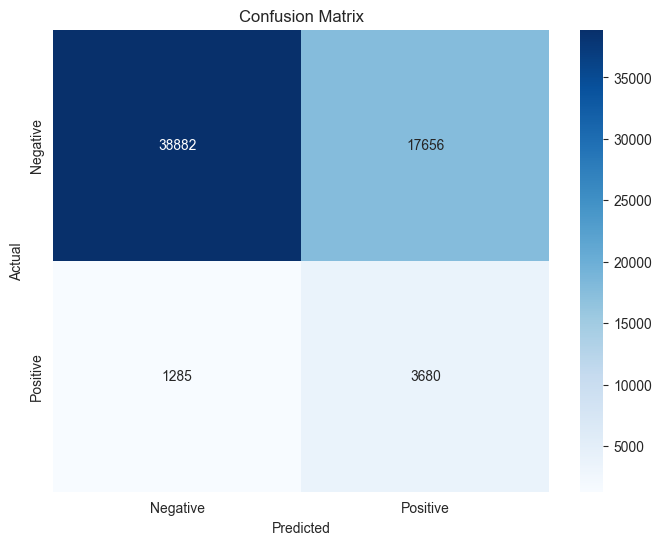

In [180]:
best_pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('resampler', SMOTE(random_state=0)),
        ('clasiffier', LGBMClassifier(scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),random_state=0, verbose=-1))
])
best_pipeline.fit(X_train, y_train)

preds_val = best_pipeline.predict(X_val)
cm = confusion_matrix(y_val, preds_val)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [268]:
best_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_biner', 'passthrough',
                                                  array(['flag_phone', 'flag_email', 'flag_cont_mobile', 'flag_work_phone',
       'flag_emp_phone'], dtype=object)),
                                                 ('num_discrete',
                                                  MinMaxScaler(),
                                                  array(['cnt_fam_members', 'region_rating_client', 'flag_document_sum',
       'hour_sin', 'hour_cos', 'weekday_appr_process_start_code',
       '...
                                                   'days_last_phone_change',
                                                   'total_ext_source',
                                                   'total_req',
                                                   'income_credit_ratio',
                                                   'age_years',
                                                   'amt_income_total',
                                                   'amt_credit', 'amt_annuity',
                                                   'amt_goods_price',
                                                   'region_population_relative',
                                                   'days_registration',
                                                   'days_id_publish',
                                                   'years_employed'])])),
                ('resampler', SMOTE(random_state=0)),
                ('clasiffier',
                 LGBMClassifier(random_state=0,
                                scale_pos_weight=11.38710976837865,
                                verbose=-1))])

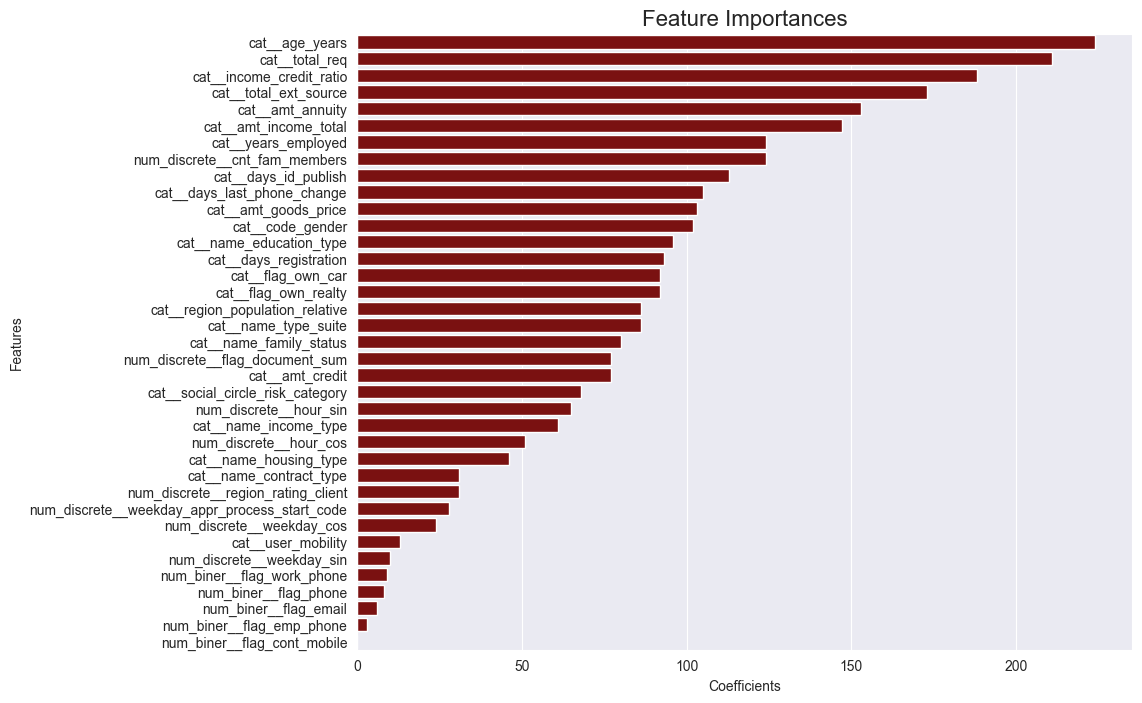

In [272]:
feature_importances = pd.DataFrame(best_pipeline['clasiffier'].feature_importances_,
                                   preprocessor.get_feature_names_out(),
                                   columns=['Coefficients']).sort_values('Coefficients', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficients', y=feature_importances.index, data=feature_importances, color='darkred')

plt.title('Feature Importances', fontsize=16)
plt.xlabel('Coefficients')
plt.ylabel('Features')

plt.show()


Threshold: 0.30
False Negatives: 428 (Kasus default yang terlewat)
False Positives: 33638 (Non-default yang salah prediksi)
Recall Default: 91.38%

Threshold: 0.40
False Negatives: 798 (Kasus default yang terlewat)
False Positives: 24886 (Non-default yang salah prediksi)
Recall Default: 83.93%

Threshold: 0.50
False Negatives: 1285 (Kasus default yang terlewat)
False Positives: 17656 (Non-default yang salah prediksi)
Recall Default: 74.12%

Threshold: 0.60
False Negatives: 1877 (Kasus default yang terlewat)
False Positives: 11942 (Non-default yang salah prediksi)
Recall Default: 62.20%


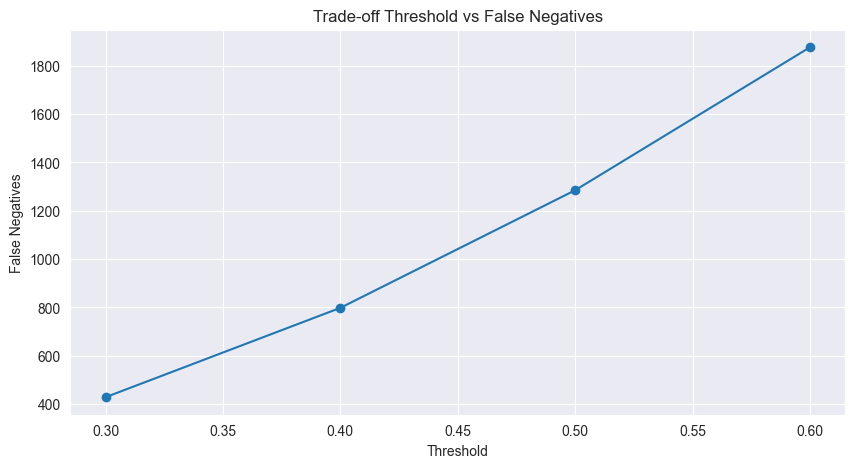

In [256]:
y_val_pred_proba = best_pipeline.predict_proba(X_val)[:, 1]

# Fungsi untuk evaluasi threshold
def evaluate_threshold(y_true, y_proba, threshold):
    y_pred = (y_proba >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\nThreshold: {threshold:.2f}")
    print(f"False Negatives: {fn} (Kasus default yang terlewat)")
    print(f"False Positives: {fp} (Non-default yang salah prediksi)")
    print(f"Recall Default: {tp/(tp+fn):.2%}")
    
    return fn  # Return false negatives untuk analisis

# Coba berbagai threshold
thresholds = [0.3, 0.4, 0.5, 0.6]
false_negatives = []

for thresh in thresholds:
    fn = evaluate_threshold(y_val, y_val_pred_proba, thresh)
    false_negatives.append(fn)

# Visualisasi trade-off
plt.figure(figsize=(10,5))
plt.plot(thresholds, false_negatives, marker='o')
plt.title('Trade-off Threshold vs False Negatives')
plt.xlabel('Threshold')
plt.ylabel('False Negatives')
plt.grid(True)
plt.show()

In [ ]:
#Preprocess data test (pastikan sama seperti data train)
X_test_preprocessed = preprocessor.transform(X_test)  # Gunakan preprocessor yang sama

# Prediksi probabilitas default
y_pred_proba = model.predict(X_test_preprocessed)  # Output: probabilitas kelas 1 (default)

# Convert ke prediksi biner (threshold terbaik 0.3 untuk maksimalkan recall)
y_pred = (y_pred_proba >= 0.3).astype(int)

In [259]:
y_pred

array([0, 1, 1, ..., 0, 0, 1])

In [260]:
test_id = pd.Series (pd.read_csv(r"C:\Users\tamar\Downloads\home-credit-default-risk\application_test.csv")['SK_ID_CURR'])

In [261]:
X_test_with_id = pd.concat([X_test, test_id], axis=1)

In [263]:
final_predictions = pd.DataFrame({
    'ID': X_test_with_id['SK_ID_CURR'], 
    'Default_Probability': y_pred_proba
})

final_predictions.to_csv('predictions_with_opt_threshold.csv', index=False)

In [264]:
final_predictions

,ID,Default_Probability
0,100001,0.0
1,100005,1.0
2,100013,1.0
3,100028,0.0
4,100038,1.0
...,...,...
48739,456221,0.0
48740,456222,1.0
48741,456223,0.0
48742,456224,0.0


## Score Card Tradisional dengan Logistic Regression

In [196]:
lr = pipeline_lr_sample.named_steps['clasiffier']
coefficients = lr.coef_[0]

In [198]:
coefficients

array([-0.03481106, -0.04441581, -0.13654989,  0.02801121, -0.15671303,
        0.30855112, -0.07130009, -1.3020918 , -0.03285415, -0.50892449,
       -0.13758356, -0.06480945, -0.12622805,  2.24489064,  0.62847482,
        1.84835264, -1.26409299,  0.03927092,  0.76874483,  0.10347296,
       -0.33110641, -0.18001221,  0.1203214 ,  0.77453043,  0.2423643 ,
        1.03144679, -0.27585214,  0.47327154, -0.91567602,  0.54799451,
        0.18727571,  0.48171892,  0.01616038,  0.24954358,  0.41664697,
        0.44337239,  0.45304323])

In [199]:
preprocessor

ColumnTransformer(transformers=[('num_biner', 'passthrough',
                                 array(['flag_phone', 'flag_email', 'flag_cont_mobile', 'flag_work_phone',
       'flag_emp_phone'], dtype=object)),
                                ('num_discrete', MinMaxScaler(),
                                 array(['cnt_fam_members', 'region_rating_client', 'flag_document_sum',
       'hour_sin', 'hour_cos', 'weekday_appr_process_start_code',
       'weekday_sin', 'weekday_cos'], dtyp...
                                  'name_family_status', 'name_housing_type',
                                  'user_mobility',
                                  'social_circle_risk_category',
                                  'name_education_type',
                                  'days_last_phone_change', 'total_ext_source',
                                  'total_req', 'income_credit_ratio',
                                  'age_years', 'amt_income_total', 'amt_credit',
                                  'amt_annuity', 'amt_goods_price',
                                  'region_population_relative',
                                  'days_registration', 'days_id_publish',
                                  'years_employed'])])

In [200]:
pipeline_lr_sample

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_biner', 'passthrough',
                                                  array(['flag_phone', 'flag_email', 'flag_cont_mobile', 'flag_work_phone',
       'flag_emp_phone'], dtype=object)),
                                                 ('num_discrete',
                                                  MinMaxScaler(),
                                                  array(['cnt_fam_members', 'region_rating_client', 'flag_document_sum',
       'hour_sin', 'hour_cos', 'weekday_appr_process_start_code',
       '...
                                                   'days_last_phone_change',
                                                   'total_ext_source',
                                                   'total_req',
                                                   'income_credit_ratio',
                                                   'age_years',
                                                   'amt_income_total',
                                                   'amt_credit', 'amt_annuity',
                                                   'amt_goods_price',
                                                   'region_population_relative',
                                                   'days_registration',
                                                   'days_id_publish',
                                                   'years_employed'])])),
                ('resampler', SMOTE(random_state=0)),
                ('clasiffier',
                 LogisticRegression(class_weight='balanced', n_jobs=-1,
                                    random_state=0))])

In [201]:
intercept = lr.intercept_[0]
intercept

0.8056110348347943

In [218]:
base_score = round(intercept * 50)
base_score

40

In [203]:
# Daftar fitur setelah preprocessing
num_biner_features = preprocessor.named_transformers_['num_biner'].get_feature_names_out()
num_discrete_features = preprocessor.named_transformers_['num_discrete'].get_feature_names_out()
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out()

all_features_ordered = np.concatenate([
    num_biner_features,  # Fitur biner (passthrough)
    cat_features,        # Fitur kategorikal (WOE)
    num_discrete_features  # Fitur diskrit (MinMax)
])

In [206]:
woe_encoder = preprocessor.named_transformers_['cat']
woe_mapping = woe_encoder.mapping  # Dictionary berisi mapping WOE per fitur kategorikal

In [207]:
base_score = round(intercept * 50 + 0)  # Contoh scaling: intercept * factor + offset
base_score

40

In [209]:
value_mapping = {}
for feature in cat_features:
    unique_values = X_train[feature].unique()
    value_mapping[feature] = {
        1: unique_values[0] if len(unique_values) > 0 else 'Unknown',
        2: unique_values[1] if len(unique_values) > 1 else 'Unknown',
        -1: 'Missing',  # Kode -1 untuk missing values
        -2: 'New'       # Kode -2 untuk nilai baru
    }

In [213]:
scaling_factor = 50
scorecard_data = []

for i, feature in enumerate(cat_features, start=len(num_biner_features)):
    if feature in woe_mapping:
        woe_values = woe_mapping[feature]
        coef = coefficients[i]
        unique_values = X_train[feature].dropna().unique()
        
        for category_code, woe in woe_values.items():
            # Skip missing/new categories dan kode tidak valid
            if category_code in [-1, -2] or not (1 <= category_code <= len(unique_values)):
                continue
            
            # Ambil nama asli tanpa fallback
            category_name = unique_values[category_code - 1]
            
            raw_score = woe * coef
            points = round(raw_score * scaling_factor, 2)
            
            scorecard_data.append({
                'Variable': feature,
                'Original_Category': category_name,
                'WOE': woe,
                'Coefficient': coef,
                'Contributions': raw_score,
                'Points': points
            })

# Proses fitur NUMERIK (Biner + Diskrit)
for i, feature in enumerate(list(num_biner_features) + list(num_discrete_features)):
    coef = coefficients[i] if i < len(num_biner_features) else coefficients[i + len(cat_features)]
    points = round(coef * scaling_factor, 2)
    
    scorecard_data.append({
        'Variable': feature,
        'WOE': None,
        'Coefficient': coef,
        'Points': points
    })

# Hasil akan hanya berisi kategori asli yang ada di data training
scorecard_df = pd.DataFrame(scorecard_data)

In [289]:
scorecard_df.head(10)

,Variable,Original_Category,Points,WOE,Coefficient,Contributions
0,Base,intercept,626.00,NaN,NaN,NaN
0,name_contract_type,Cash loans,0.57,0.036746,0.308551,0.011338
1,name_contract_type,Revolving loans,-6.57,-0.425824,0.308551,-0.131389
2,code_gender,M,-0.92,0.258859,-0.071300,-0.018457
3,code_gender,F,0.57,-0.159642,-0.071300,0.011383
4,flag_own_car,N,-3.50,0.053768,-1.302092,-0.070011
5,flag_own_car,Y,7.28,-0.111782,-1.302092,0.145551
6,flag_own_realty,Y,0.02,-0.013154,-0.032854,0.000432
7,flag_own_realty,N,-0.05,0.029207,-0.032854,-0.000960
8,name_type_suite,Unaccompanied,-0.32,0.012624,-0.508924,-0.006424


In [219]:
if 'base' not in scorecard_df['Variable'].values:
    scorecard_df = pd.concat([
        pd.DataFrame([{'Variable': 'Base', 'Original_Category': 'intercept', 'Points': base_score}]),
        scorecard_df
    ])

In [237]:
def calculate_client_score(client_data, scorecard_df):
    """
    Menghitung total skor kredit untuk satu klien (termasuk num_discrete_features)
    
    Parameters:
    - client_data: Series/DataFrame (1 row) berisi data klien
    - scorecard_df: DataFrame scorecard
    
    Returns:
    - Dictionary berisi total skor dan breakdown poin
    """
    score_breakdown = {}
    total_score = 0
    
    for _, rule in scorecard_df.iterrows():
        var = rule['Variable']
        
        # 1. Handle base score
        if var == 'Base':
            score_breakdown[var] = rule['Points']
            total_score += rule['Points']
            continue
            
        # 2. Skip jika fitur tidak ada di data klien
        if var not in client_data:
            continue
            
        # 3. Handle categorical features (termasuk yang sudah di-bin)
        if var in cat_features:
            client_value = str(client_data[var])
            if client_value == rule['Original_Category']:
                score_breakdown[var] = rule['Points']
                total_score += rule['Points']
                
        # 4. Handle binary features (0/1)
        elif var in num_biner_features:
            if client_data[var] in [0, 1]:
                matched_rule = scorecard_df[
                    (scorecard_df['Variable'] == var) & 
                    (scorecard_df['Original_Category'] == str(client_data[var]))
                ]
                if not matched_rule.empty:
                    points = matched_rule.iloc[0]['Points']
                    score_breakdown[var] = points
                    total_score += points
        
        # 5. Handle num_discrete_features (tidak di-bin)
        elif var in num_discrete_features:
            # Langsung ambil poin dari scorecard (asumsi 1 rule per fitur)
            points = rule['Points']
            score_breakdown[var] = points
            total_score += points
    
    return {
        'total_score': total_score,
        'score_breakdown': score_breakdown
    }

In [238]:
results = []

for _, client in X_test_with_id.iterrows():
    client_id = client['SK_ID_CURR'] 
    score_result = calculate_client_score(client, scorecard_df)
    
    results.append({
        'application_id': client_id,
        'credit_score': score_result['total_score'],
        **score_result['score_breakdown'] 
    })

In [239]:
client_scores = pd.DataFrame(results)
client_scores

,application_id,credit_score,Base,name_contract_type,code_gender,flag_own_car,flag_own_realty,name_type_suite,name_income_type,name_family_status,name_housing_type,user_mobility,social_circle_risk_category,name_education_type,cnt_fam_members,region_rating_client,flag_document_sum,hour_sin,hour_cos,weekday_appr_process_start_code,weekday_sin,weekday_cos
0,100001,196.19,40.0,0.57,0.57,-3.50,0.02,-0.32,-1.28,0.23,0.24,-12.33,-1.27,33.47,27.4,9.36,24.09,0.81,12.48,20.83,22.17,22.65
1,100005,171.49,40.0,0.57,-0.92,-3.50,0.02,-0.32,-1.28,0.23,0.24,-12.33,-1.27,10.26,27.4,9.36,24.09,0.81,12.48,20.83,22.17,22.65
2,100013,205.80,40.0,0.57,-0.92,7.28,0.02,NaN,-1.28,0.23,0.24,-12.33,-1.27,33.47,27.4,9.36,24.09,0.81,12.48,20.83,22.17,22.65
3,100028,172.98,40.0,0.57,0.57,-3.50,0.02,-0.32,-1.28,0.23,0.24,-12.33,-1.27,10.26,27.4,9.36,24.09,0.81,12.48,20.83,22.17,22.65
4,100038,229.30,40.0,0.57,-0.92,7.28,-0.05,-0.32,-1.28,0.23,0.24,34.77,-1.27,10.26,27.4,9.36,24.09,0.81,12.48,20.83,22.17,22.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,173.85,40.0,0.57,0.57,-3.50,0.02,-0.32,-1.28,1.10,0.24,-12.33,-1.27,10.26,27.4,9.36,24.09,0.81,12.48,20.83,22.17,22.65
48740,456222,221.82,40.0,0.57,0.57,-3.50,-0.05,-0.32,0.53,0.23,0.24,34.77,-1.27,10.26,27.4,9.36,24.09,0.81,12.48,20.83,22.17,22.65
48741,456223,185.57,40.0,0.57,0.57,7.28,0.02,-0.32,0.53,0.23,0.24,-12.33,-1.27,10.26,27.4,9.36,24.09,0.81,12.48,20.83,22.17,22.65
48742,456224,223.22,40.0,0.57,-0.92,-3.50,-0.05,2.24,0.53,0.23,0.24,11.89,-1.27,33.47,27.4,9.36,24.09,0.81,12.48,20.83,22.17,22.65


In [240]:
# Normalisasi ke skala 300-850
min_score = client_scores['credit_score'].min()
max_score = client_scores['credit_score'].max()

client_scores['normalized_score'] = client_scores['credit_score'].apply(
    lambda x: int(300 + (850 - 300) * (x - min_score) / (max_score - min_score))
)

In [265]:
client_scores[['application_id','normalized_score']]

,application_id,normalized_score
0,100001,591
1,100005,505
2,100013,625
3,100028,510
4,100038,707
...,...,...
48739,456221,513
48740,456222,680
48741,456223,554
48742,456224,685


In [253]:
final_predictions

,ID,Default_Probability
0,100001,0.0
1,100005,1.0
2,100013,1.0
3,100028,0.0
4,100038,1.0
...,...,...
48739,456221,0.0
48740,456222,1.0
48741,456223,0.0
48742,456224,0.0


In [245]:
all_coefficients = scorecard_df[scorecard_df['Variable'] != 'Base']['Coefficient']
min_coef = all_coefficients.min()
max_coef = all_coefficients.max()
range_coef = max_coef - min_coef

In [250]:
base_score_normalized = int(
    300 + (intercept - min_coef) * ((850-300) / range_coef)
)

base_score_normalized

626

**Pipeline logistic regression saya peruntukan untuk membangun score card dan LGBM (hasil evaluasi recall dan fbeta score terbaik) untuk prediksi default**

- Saat nasabah Apply Pinjaman:

    - Sistem akan hitung skor kredit dengan scorecard Logistic Regression (untuk tampilkan ke nasabah).
    - Secara paralel, prediksi risiko default pakai LGBM (untuk keputusan internal).

- Keputusan Gabungan:

Jika scorecard menunjukkan skor < 550 ATAU prediksi LGBM > threshold risiko --> Tolak/tinjau ulang aplikasi.

In [267]:
#y_pred_proba_lgbm = best_pipeline.predict_proba(X_val)[:, 1]
# Gabungkan proba dari LGBM dan skor dari LogReg
#client_scores['final_decision'] = 0.7 * y_pred_proba_lgbm + 0.3 * client_scores['normalized_score']
#client_scores['final_label'] = np.where(client_scores['final_decision'] >= 0.3, 1, 0)